In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from colorama import Fore

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf 

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import math

# 5G Core network’s AMF

file: *amf-performance.csv*

For testing we use my5G-RANTester, a tool for emulating control and data planes of the UE and gNB (5G base station). The number of simultaneous registration requests that are sent to each instance of the AMF varies between 10 and 400.

The information available in the dataset are as follows:

- **time**: timestamp of collection of metrics
- **ram_limit**: the memory allocated to the container in megabytes
- **cpu_limit**: the CPU allocated to the container
- **ram_usage**: the amount of memory used by the container at the time of the metrics collection in byte
- **cpu_usage**: the amount of CPU used by the container at the time of the metrics collection
- **n**: the number of parallel registration requests sent to the AMF (load of the application)
- **mean**: the mean registration time for all the registration requests in microseconds (response time?)
- **lat50**: the median registration time for registration requests in microseconds
- **lat75**: the least registration time for the best 75% registration requests in microseconds
- **lat80**: the least registration time for the best 80% registration requests in microseconds
- **lat90**: the least registration time for the best 90% registration requests in microseconds
- **lat95**: the least registration time for the best 95% registration requests in microseconds
- **lat98**: the least registration time for the best 98% registration requests in microseconds
- **lat99**: the least registration time for the best 99% registration requests in microseconds
- **lat100**: the least registration time in microseconds.

In [4]:
df = pd.read_csv("./data/amf-performance.csv") # notebook must be executed from root directory
df.head()

time ram_limit  cpu_limit    ram_usage  cpu_usage   n    mean  \
0  1636553178     2048M        2.0   75722752.0   0.003700  10  194402   
1  1636553188     2048M        2.0  140255232.0   0.003700  20  301621   
2  1636553199     2048M        2.0  184238080.0   0.052663  30  465659   
3  1636553210     2048M        2.0  217681920.0   0.052663  40  592062   
4  1636553221     2048M        2.0  305606656.0   0.120889  50  862765   

    lat50   lat75   lat80   lat90   lat95   lat98   lat99  lat100  
0  210678  213100  213100  214159  214159  214159  214159  215513  
1  304027  308525  308525  309958  310981  310981  310981  314733  
2  465392  475688  476531  478613  478834  480902  480902  481993  
3  588150  609254  610635  611193  611902  617177  617177  622648  
4  863232  871812  874362  884286  885768  887802  887802  889625

In [5]:
pd.DataFrame(df.describe().iloc[:,3])

cpu_usage
count  27413.000000
mean       0.434270
std        0.363546
min        0.000000
25%        0.079990
50%        0.367726
75%        0.668056
max        1.445758

In [6]:
# Convert timestamps to pandas datetime format
df['human_date'] = pd.to_datetime(df['time'], unit='s')

# Format the datetime column as a human-readable date
df['human_date'] = df['human_date'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Move the 'human_date' column to the second position
df = df[['time', 'human_date'] + [col for col in df.columns if col != 'time' and col != 'human_date']]

df

time           human_date ram_limit  cpu_limit    ram_usage  \
0      1636553178  2021-11-10 14:06:18     2048M        2.0   75722752.0   
1      1636553188  2021-11-10 14:06:28     2048M        2.0  140255232.0   
2      1636553199  2021-11-10 14:06:39     2048M        2.0  184238080.0   
3      1636553210  2021-11-10 14:06:50     2048M        2.0  217681920.0   
4      1636553221  2021-11-10 14:07:01     2048M        2.0  305606656.0   
...           ...                  ...       ...        ...          ...   
27408  1638001157  2021-11-27 08:19:17     3328M        1.0  831762432.0   
27409  1638001169  2021-11-27 08:19:29     3328M        1.0  420741120.0   
27410  1638001184  2021-11-27 08:19:44     3328M        1.0  427098112.0   
27411  1638001196  2021-11-27 08:19:56     3328M        1.0  432287744.0   
27412  1638001209  2021-11-27 08:20:09     3328M        1.0  432582656.0   

       cpu_usage    n     mean    lat50    lat75    lat80    lat90    lat95  \
0       0.003700   10   194402   210678   213100   213100   214159   214159   
1       0.003700   20   301621   304027   308525   308525   309958   310981   
2       0.052663   30   465659   465392   475688   476531   478613   478834   
3       0.052663   40   592062   588150   609254   610635   611193   611902   
4       0.120889   50   862765   863232   871812   874362   884286   885768   
...          ...  ...      ...      ...      ...      ...      ...      ...   
27408   0.470948   80  1311496  1374454  1395385  1398698  1411853  1415445   
27409   0.248292   90  1663628  1793633  2009127  2016343  2094707  2102242   
27410   0.579697  100  4243770  4414612  4534455  4537277  4564669  4614778   
27411   0.475063  110  2152941  2262854  2293527  2297161  2364524  2365947   
27412   0.328475  120  2301817  2385211  2682019  2688866  2778968  2794159   

         lat98    lat99   lat100  
0       214159   214159   215513  
1       310981   310981   314733  
2       480902   480902   481993  
3       617177   617177   622648  
4       887802   887802   889625  
...        ...      ...      ...  
27408  1418593  1418863  1420424  
27409  2115644  2119054  2122331  
27410  4616102  4616678  4633962  
27411  2366899  2368794  2369801  
27412  2864952  2865436  2873102  

[27413 rows x 16 columns]

C:\Users\Alice Piemonti\AppData\Local\Temp\ipykernel_12152\1692855907.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sns.lineplot(x=df_short['human_date'], y=df_short[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
C:\Users\Alice Piemonti\AppData\Local\Temp\ipykernel_12152\1692855907.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sns.lineplot(x=df_short['human_date'], y=df_short[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
C:\Users\Alice Piemonti\AppData\Local\Temp\ipykernel_12152\1692855907.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sns.lineplot(x=df_short['human_date'], y=df_short[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
C:\Users\Alice Piemonti\AppD

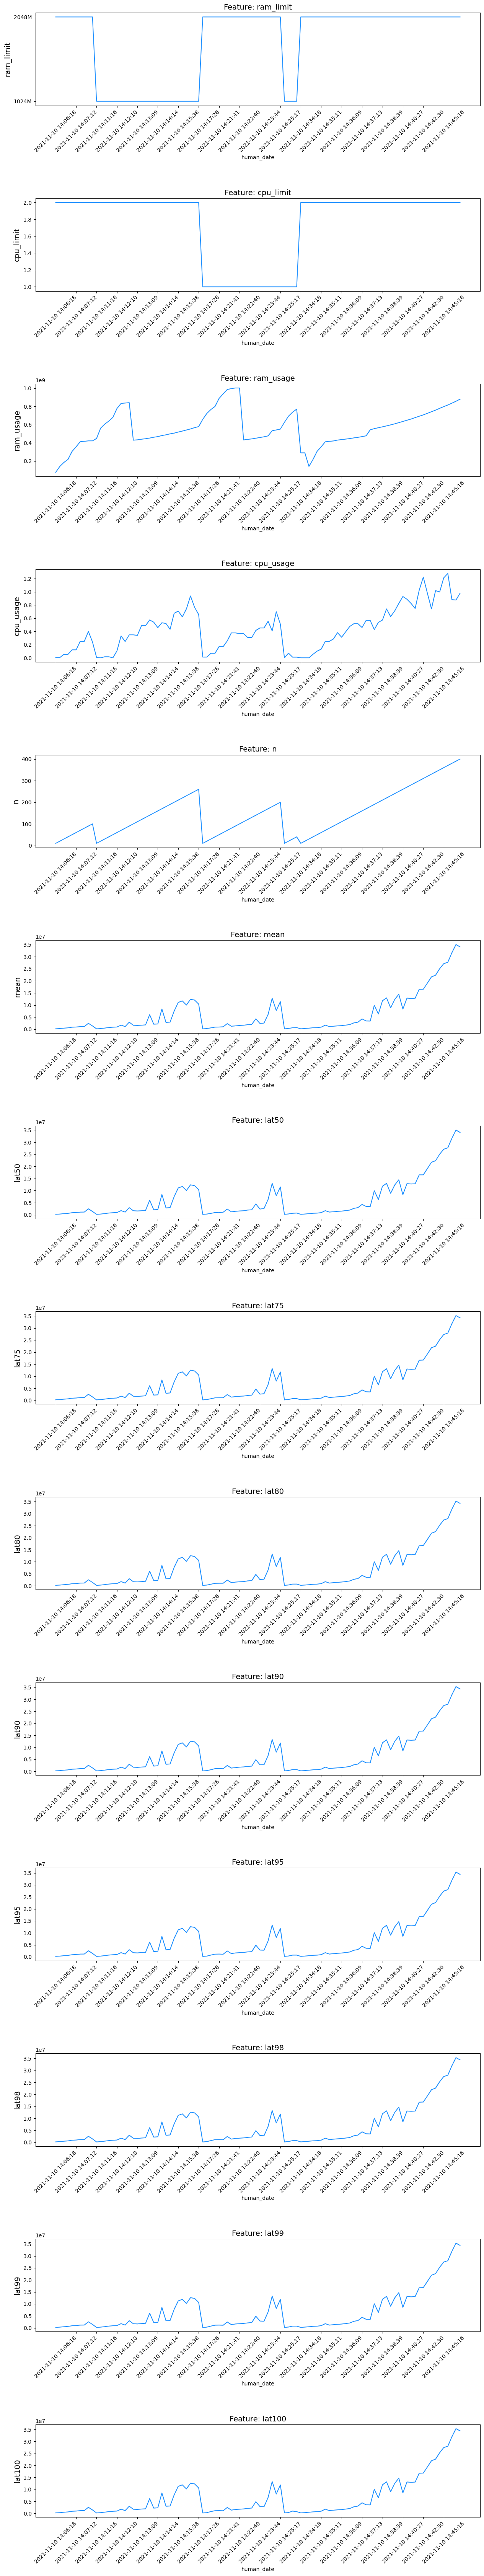

In [7]:
#reduce df length
df_short = df.iloc[:100, 1:]

# To compelte the data, as naive method, we will use ffill
f, ax = plt.subplots(nrows=df_short.shape[1] - 1, ncols=1, figsize=(15, 85))

# Set the step size for x-axis labels
x_ticks_step = 5  

# Adjust space between subplots
plt.subplots_adjust(hspace=1)

for i, column in enumerate(df_short.drop('human_date', axis=1).columns):
    sns.lineplot(x=df_short['human_date'], y=df_short[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xticks(ax[i].get_xticks()[::x_ticks_step])
    ax[i].tick_params(axis='x', rotation=45)

In [8]:
# Chronological order and equidistand timestamps
df = df.sort_values(by='human_date')

# Check time intervals
df['delta'] = df['time'] - df['time'].shift(1)

df[['time', 'delta']].head()

time  delta
0  1636553178    NaN
1  1636553188   10.0
2  1636553199   11.0
3  1636553210   11.0
4  1636553221   11.0

In [9]:
df['delta'].sum(), df['delta'].count()

(1448031.0, 27412)

In [10]:
# Resample the DataFrame to equally spaced observations every 10 seconds
frequency = '120S'  # 10 seconds
df['datetime'] = pd.to_datetime(df['time'], unit='s') # resample function needs a datetime column
resampled_df = df.resample(frequency, on='datetime').max()  # You can choose a different aggregation function

resampled_df


C:\Users\Alice Piemonti\AppData\Local\Temp\ipykernel_12152\3973718951.py:4: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  resampled_df = df.resample(frequency, on='datetime').max()  # You can choose a different aggregation function


time           human_date ram_limit  cpu_limit  \
datetime                                                                      
2021-11-10 14:06:00  1.636553e+09  2021-11-10 14:07:58     2048M        2.0   
2021-11-10 14:08:00           NaN                  NaN       NaN        NaN   
2021-11-10 14:10:00  1.636554e+09  2021-11-10 14:11:59     1024M        2.0   
2021-11-10 14:12:00  1.636554e+09  2021-11-10 14:13:49     1024M        2.0   
2021-11-10 14:14:00  1.636554e+09  2021-11-10 14:15:38     1024M        2.0   
...                           ...                  ...       ...        ...   
2021-11-27 08:12:00  1.638001e+09  2021-11-27 08:13:53     3584M        1.0   
2021-11-27 08:14:00  1.638001e+09  2021-11-27 08:14:30     3584M        1.0   
2021-11-27 08:16:00  1.638001e+09  2021-11-27 08:17:59     3328M        1.0   
2021-11-27 08:18:00  1.638001e+09  2021-11-27 08:19:56     3328M        1.0   
2021-11-27 08:20:00  1.638001e+09  2021-11-27 08:20:09     3328M        1.0   

                       ram_usage  cpu_usage      n        mean       lat50  \
datetime                                                                     
2021-11-10 14:06:00  421892096.0   0.399306  100.0   2462652.0   2459078.0   
2021-11-10 14:08:00          NaN        NaN    NaN         NaN         NaN   
2021-11-10 14:10:00  681287680.0   0.016066   50.0    858051.0    858390.0   
2021-11-10 14:12:00  842719232.0   0.573533  140.0   6028824.0   6009261.0   
2021-11-10 14:14:00  519012352.0   0.707430  210.0  11102339.0  11097458.0   
...                          ...        ...    ...         ...         ...   
2021-11-27 08:12:00  691265536.0   0.054102   60.0   1165810.0   1168774.0   
2021-11-27 08:14:00  828846080.0   0.432960   90.0   2469281.0   2569074.0   
2021-11-27 08:16:00  488726528.0   0.044293   10.0    204828.0    205670.0   
2021-11-27 08:18:00  831762432.0   0.579697  110.0   4243770.0   4414612.0   
2021-11-27 08:20:00  432582656.0   0.328475  120.0   2301817.0   2385211.0   

                          lat75       lat80       lat90       lat95  \
datetime                                                              
2021-11-10 14:06:00   2502407.0   2511058.0   2521220.0   2531593.0   
2021-11-10 14:08:00         NaN         NaN         NaN         NaN   
2021-11-10 14:10:00    870854.0    871670.0    883309.0    884418.0   
2021-11-10 14:12:00   6077913.0   6093355.0   6117166.0   6131208.0   
2021-11-10 14:14:00  11196910.0  11204677.0  11222205.0  11260877.0   
...                         ...         ...         ...         ...   
2021-11-27 08:12:00   1361263.0   1445301.0   1452886.0   1478451.0   
2021-11-27 08:14:00   2960235.0   3045520.0   3133486.0   3163211.0   
2021-11-27 08:16:00    207363.0    207363.0    208367.0    208367.0   
2021-11-27 08:18:00   4534455.0   4537277.0   4564669.0   4614778.0   
2021-11-27 08:20:00   2682019.0   2688866.0   2778968.0   2794159.0   

                          lat98       lat99      lat100  delta  
datetime                                                        
2021-11-10 14:06:00   2535056.0   2536014.0   2538040.0   13.0  
2021-11-10 14:08:00         NaN         NaN         NaN    NaN  
2021-11-10 14:10:00    884678.0    884678.0    885658.0  198.0  
2021-11-10 14:12:00   6134158.0   6134457.0   6157805.0   16.0  
2021-11-10 14:14:00  11269412.0  11271078.0  11291590.0   21.0  
...                         ...         ...         ...    ...  
2021-11-27 08:12:00   1480896.0   1484014.0   1546756.0  208.0  
2021-11-27 08:14:00   3231738.0   3231746.0   3237390.0   13.0  
2021-11-27 08:16:00    208367.0    208367.0    208602.0  209.0  
2021-11-27 08:18:00   4616102.0   4616678.0   4633962.0   15.0  
2021-11-27 08:20:00   2864952.0   2865436.0   2873102.0   13.0  

[12068 rows x 17 columns]

In [11]:
resampled_df = resampled_df.drop('delta', axis=1)
resampled_df.isna().sum()

time          5583
human_date    5583
ram_limit     5583
cpu_limit     5583
ram_usage     5583
cpu_usage     5583
n             5583
mean          5583
lat50         5583
lat75         5583
lat80         5583
lat90         5583
lat95         5583
lat98         5583
lat99         5583
lat100        5583
dtype: int64

Let's investigate the trade-off between low frequency and n. of null values

In [12]:
# Resample the DataFrame to equally spaced observations every n seconds
frequency_array = ['60S', '5T', '10T', '30T', '1H', '2H', '6H']
null_count_dict = {}
null_count_dict['frequency'] = []
null_count_dict['null_count'] = []

for frequency_value in frequency_array:
    df['datetime'] = pd.to_datetime(df['time'], unit='s') # resample function needs a datetime column
    new_df = df.resample(frequency_value, on='datetime').max()  # you can choose a different aggregation function
    new_df = new_df.drop('delta', axis=1) # no need of this column
    null_count_dict['frequency'].append(frequency_value)
    null_count_dict['null_count'].append(new_df['cpu_usage'].isna().sum()) # I chose cpu_usage as example but it's the same for each column

null_count_df = pd.DataFrame(null_count_dict)

C:\Users\Alice Piemonti\AppData\Local\Temp\ipykernel_12152\979825274.py:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  new_df = df.resample(frequency_value, on='datetime').max()  # you can choose a different aggregation function
C:\Users\Alice Piemonti\AppData\Local\Temp\ipykernel_12152\979825274.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  new_df = df.resample(frequency_value, on='datetime').max()  # you can choose a different aggregation function
C:\Users\Alice Piemonti\AppData\Local\Temp\ipykernel_12152\979825274.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  new_df = df.resample(frequency_value, on='datetime').max()  # you can choose a different aggregation function
C:\Users\Alice Piemonti\AppData\Local\Temp\ipykernel_12152\979825274.py:9: FutureWarning: 'T' is deprecated and will be removed in a future v

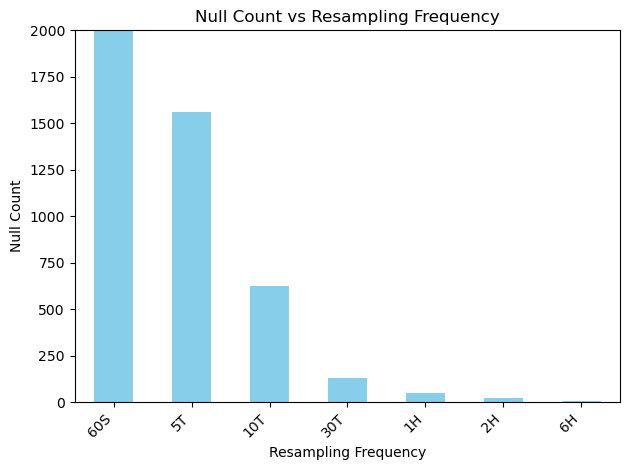

In [13]:
# Plotting the histogram
ax = null_count_df.plot(kind='bar', x='frequency', y='null_count', legend=False, color='skyblue')
ax.set_ylim(0, 2000)

plt.xlabel('Resampling Frequency')
plt.ylabel('Null Count')
plt.title('Null Count vs Resampling Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

C:\Users\Alice Piemonti\AppData\Local\Temp\ipykernel_12152\364062908.py:7: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled_df_short = resampled_df_short.reset_index().interpolate(method='ffill')
C:\Users\Alice Piemonti\AppData\Local\Temp\ipykernel_12152\364062908.py:21: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled_df_short = resampled_df_short.reset_index().interpolate(method='ffill')


Text(0, 0.5, 'RAM usage')

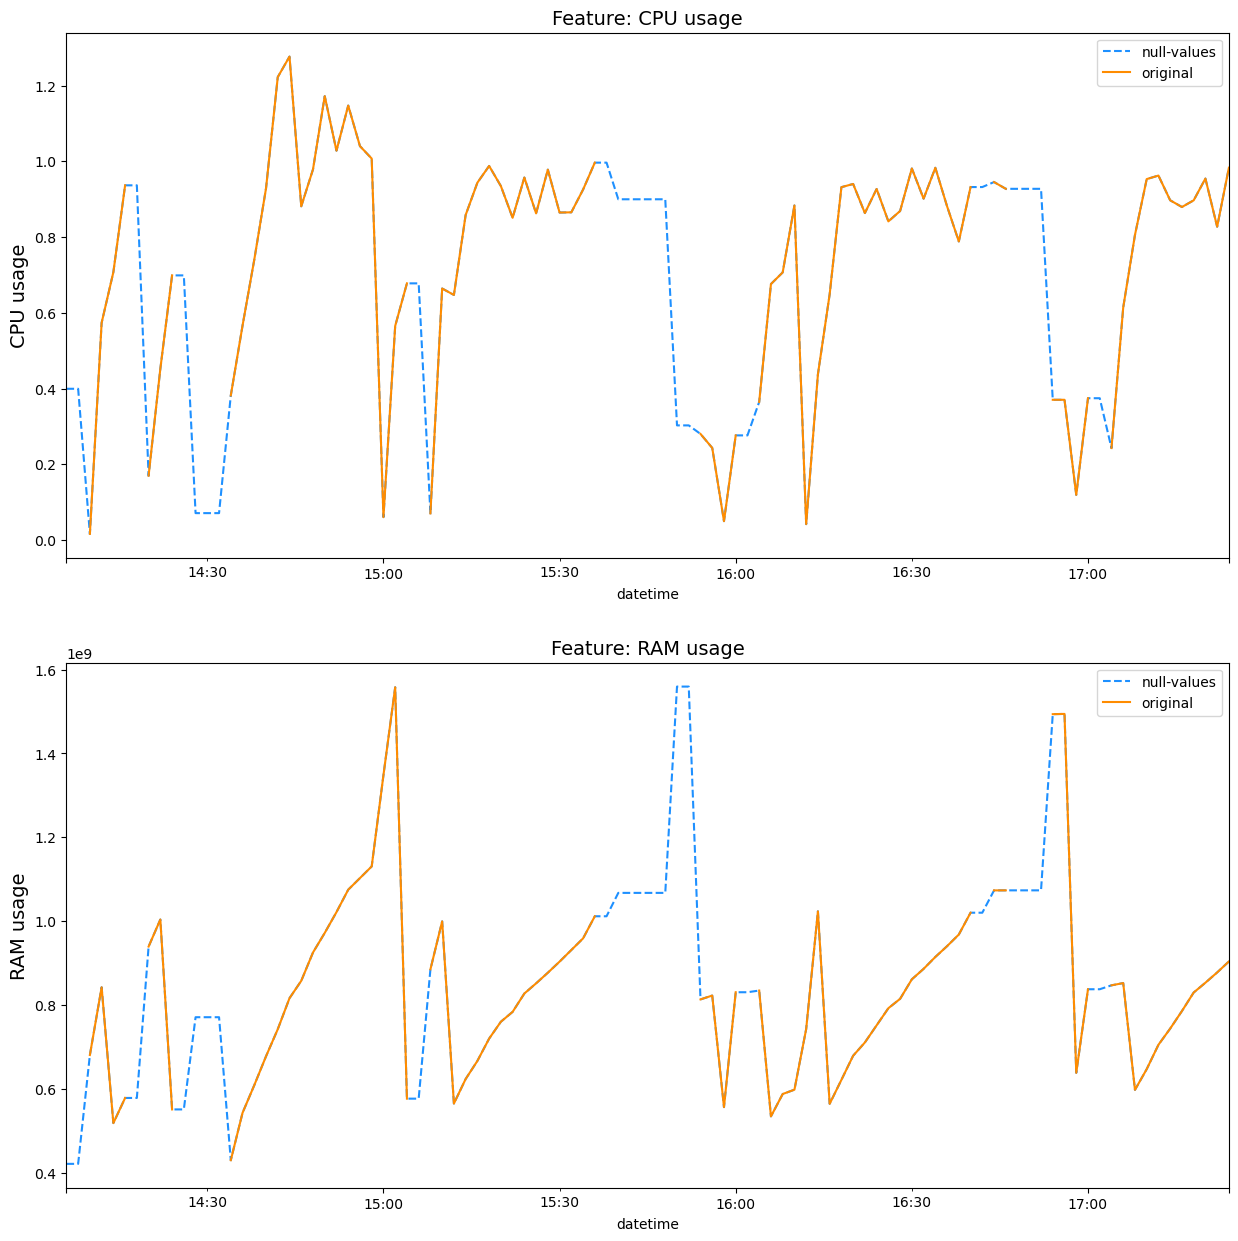

In [14]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

# prepare data CPU usage
resampled_df_short = resampled_df.copy().iloc[:100,:]
old_cpu_usage = pd.DataFrame(resampled_df_short['cpu_usage'].copy()).reset_index()
resampled_df_short['cpu_usage'] = resampled_df_short['cpu_usage'].replace(0, np.nan)
resampled_df_short = resampled_df_short.reset_index().interpolate(method='ffill')

# plot CPU usage
resampled_df_short.plot(x='datetime', y='cpu_usage', ax=ax[0], color='dodgerblue', label='null-values', linestyle='dashed')
old_cpu_usage.plot(x='datetime', y='cpu_usage', ax=ax[0], color='darkorange', label='original')

ax[0].set_title('Feature: CPU usage', fontsize=14)
ax[0].set_ylabel(ylabel='CPU usage', fontsize=14)
#ax[0].set_xlim([date(2021, 11, 10), date(2021, 11, 11)])

# prepare data RAM
resampled_df_short = resampled_df.copy().iloc[:100,:]
old_ram_usage = pd.DataFrame(resampled_df_short['ram_usage'].copy()).reset_index()
resampled_df_short['ram_usage'] = resampled_df_short['ram_usage'].replace(0, np.nan)
resampled_df_short = resampled_df_short.reset_index().interpolate(method='ffill')

# plot RAM usage
resampled_df_short.plot(x='datetime', y='ram_usage', ax=ax[1], color='dodgerblue', label='null-values', linestyle='dashed')
old_ram_usage.plot(x='datetime', y='ram_usage', ax=ax[1], color='darkorange', label='original')

ax[1].set_title('Feature: RAM usage', fontsize=14)
ax[1].set_ylabel(ylabel='RAM usage', fontsize=14)
#ax[0].set_xlim([date(2021, 11, 10), date(2021, 11, 11)])

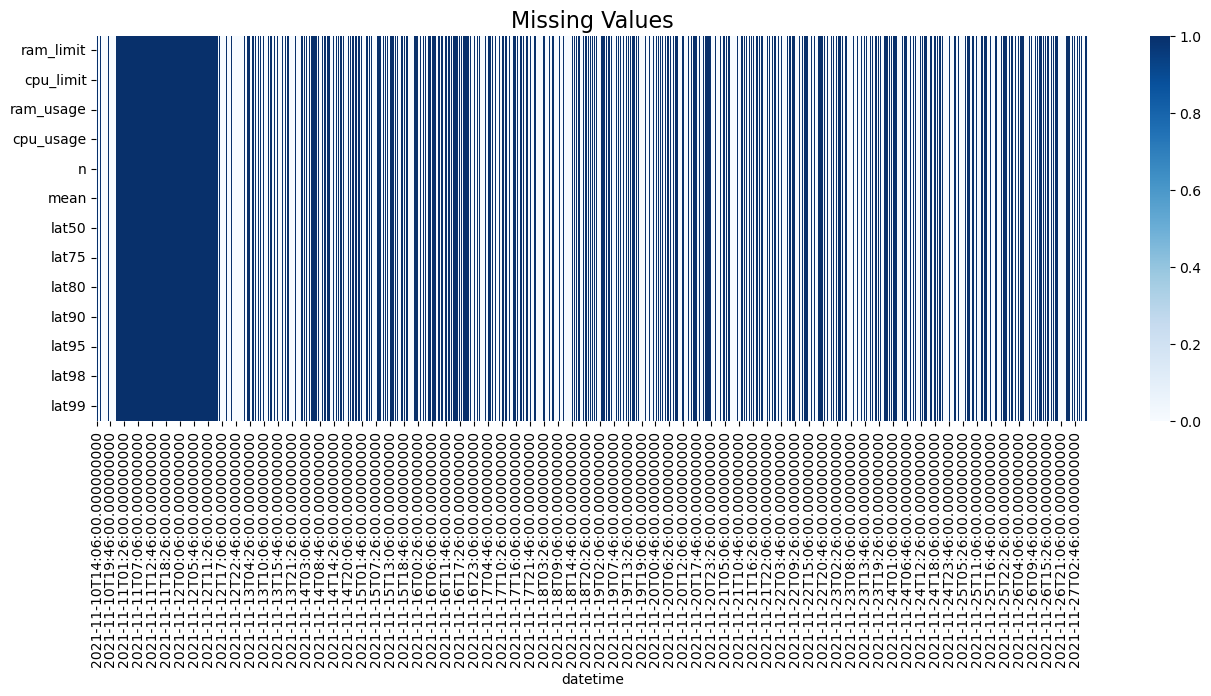

In [16]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(resampled_df.iloc[:,2:-1].T.isna(), cmap='Blues') #drop useless columns
ax.set_title('Missing Values', fontsize=16)
plt.show()

Fill missing values

In [17]:
df_filled = resampled_df.interpolate().ffill()
df_filled

C:\Users\Alice Piemonti\AppData\Local\Temp\ipykernel_12152\3446574293.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_filled = resampled_df.interpolate().ffill()


time           human_date ram_limit  cpu_limit  \
datetime                                                                      
2021-11-10 14:06:00  1.636553e+09  2021-11-10 14:07:58     2048M        2.0   
2021-11-10 14:08:00  1.636553e+09  2021-11-10 14:07:58     2048M        2.0   
2021-11-10 14:10:00  1.636554e+09  2021-11-10 14:11:59     1024M        2.0   
2021-11-10 14:12:00  1.636554e+09  2021-11-10 14:13:49     1024M        2.0   
2021-11-10 14:14:00  1.636554e+09  2021-11-10 14:15:38     1024M        2.0   
...                           ...                  ...       ...        ...   
2021-11-27 08:12:00  1.638001e+09  2021-11-27 08:13:53     3584M        1.0   
2021-11-27 08:14:00  1.638001e+09  2021-11-27 08:14:30     3584M        1.0   
2021-11-27 08:16:00  1.638001e+09  2021-11-27 08:17:59     3328M        1.0   
2021-11-27 08:18:00  1.638001e+09  2021-11-27 08:19:56     3328M        1.0   
2021-11-27 08:20:00  1.638001e+09  2021-11-27 08:20:09     3328M        1.0   

                       ram_usage  cpu_usage      n        mean       lat50  \
datetime                                                                     
2021-11-10 14:06:00  421892096.0   0.399306  100.0   2462652.0   2459078.0   
2021-11-10 14:08:00  551589888.0   0.207686   75.0   1660351.5   1658734.0   
2021-11-10 14:10:00  681287680.0   0.016066   50.0    858051.0    858390.0   
2021-11-10 14:12:00  842719232.0   0.573533  140.0   6028824.0   6009261.0   
2021-11-10 14:14:00  519012352.0   0.707430  210.0  11102339.0  11097458.0   
...                          ...        ...    ...         ...         ...   
2021-11-27 08:12:00  691265536.0   0.054102   60.0   1165810.0   1168774.0   
2021-11-27 08:14:00  828846080.0   0.432960   90.0   2469281.0   2569074.0   
2021-11-27 08:16:00  488726528.0   0.044293   10.0    204828.0    205670.0   
2021-11-27 08:18:00  831762432.0   0.579697  110.0   4243770.0   4414612.0   
2021-11-27 08:20:00  432582656.0   0.328475  120.0   2301817.0   2385211.0   

                          lat75       lat80       lat90       lat95  \
datetime                                                              
2021-11-10 14:06:00   2502407.0   2511058.0   2521220.0   2531593.0   
2021-11-10 14:08:00   1686630.5   1691364.0   1702264.5   1708005.5   
2021-11-10 14:10:00    870854.0    871670.0    883309.0    884418.0   
2021-11-10 14:12:00   6077913.0   6093355.0   6117166.0   6131208.0   
2021-11-10 14:14:00  11196910.0  11204677.0  11222205.0  11260877.0   
...                         ...         ...         ...         ...   
2021-11-27 08:12:00   1361263.0   1445301.0   1452886.0   1478451.0   
2021-11-27 08:14:00   2960235.0   3045520.0   3133486.0   3163211.0   
2021-11-27 08:16:00    207363.0    207363.0    208367.0    208367.0   
2021-11-27 08:18:00   4534455.0   4537277.0   4564669.0   4614778.0   
2021-11-27 08:20:00   2682019.0   2688866.0   2778968.0   2794159.0   

                          lat98       lat99      lat100  
datetime                                                 
2021-11-10 14:06:00   2535056.0   2536014.0   2538040.0  
2021-11-10 14:08:00   1709867.0   1710346.0   1711849.0  
2021-11-10 14:10:00    884678.0    884678.0    885658.0  
2021-11-10 14:12:00   6134158.0   6134457.0   6157805.0  
2021-11-10 14:14:00  11269412.0  11271078.0  11291590.0  
...                         ...         ...         ...  
2021-11-27 08:12:00   1480896.0   1484014.0   1546756.0  
2021-11-27 08:14:00   3231738.0   3231746.0   3237390.0  
2021-11-27 08:16:00    208367.0    208367.0    208602.0  
2021-11-27 08:18:00   4616102.0   4616678.0   4633962.0  
2021-11-27 08:20:00   2864952.0   2865436.0   2873102.0  

[12068 rows x 16 columns]

Text(0, 0.5, 'RAM usage')

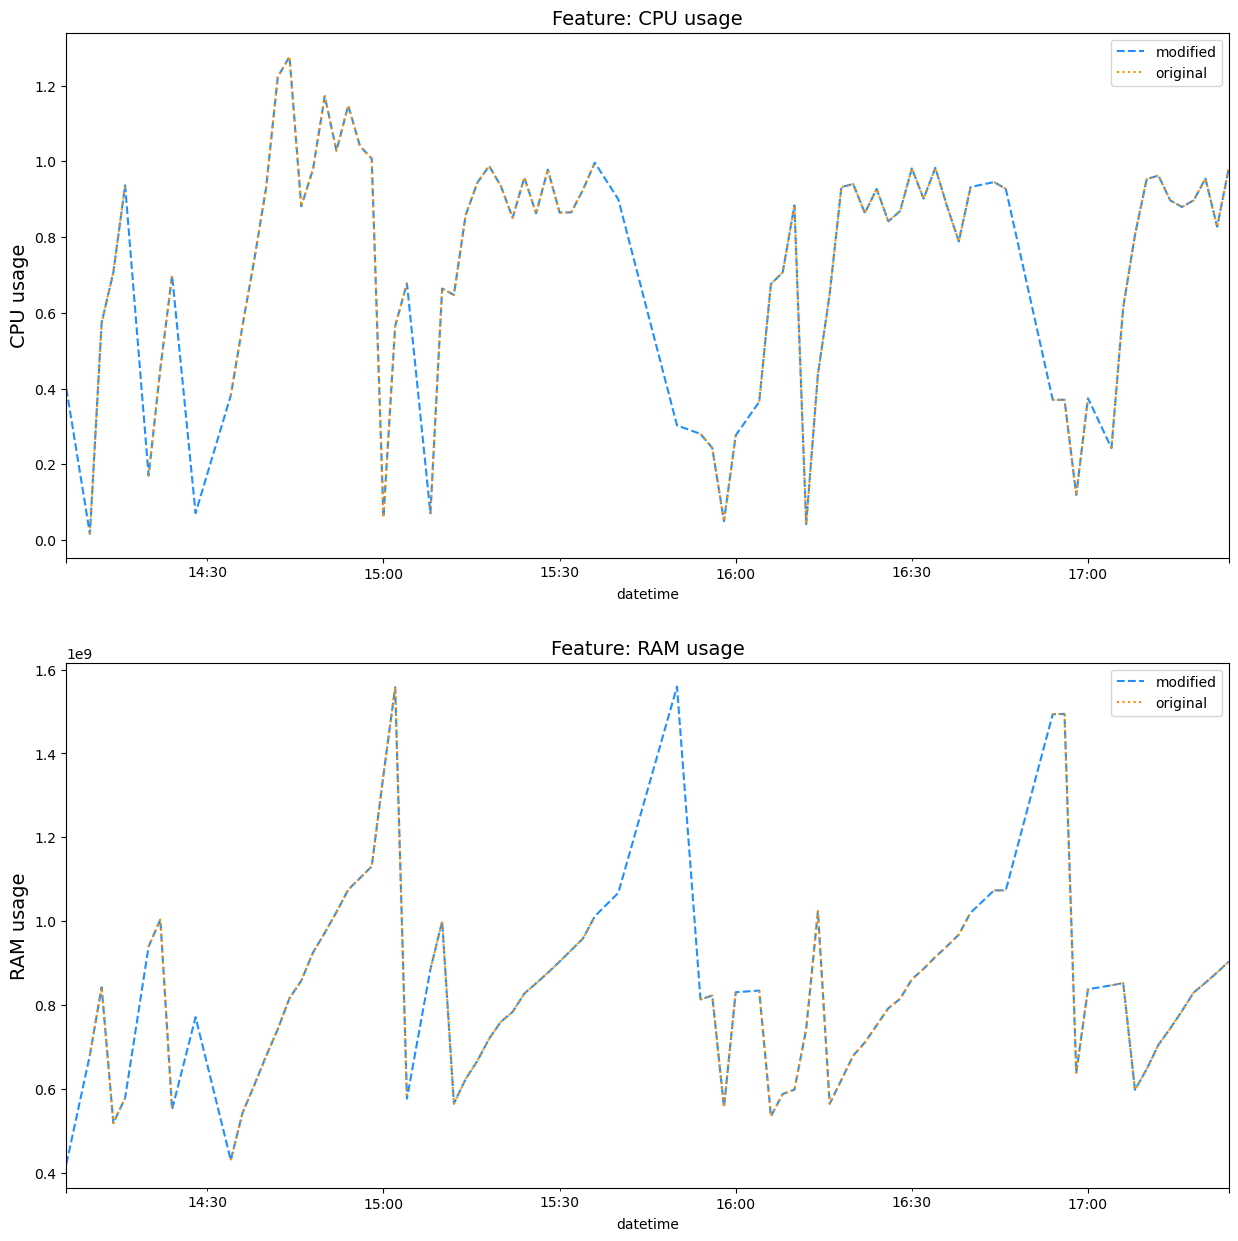

In [18]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

# prepare data CPU usage
df_filled_short = df_filled.copy().iloc[:100,:]
df_filled_short.reset_index().plot(x='datetime', y='cpu_usage', ax=ax[0], color='dodgerblue', label='modified', linestyle='dashed')
old_cpu_usage.plot(x='datetime', y='cpu_usage', ax=ax[0], color='darkorange', label='original', linestyle='dotted')


ax[0].set_title('Feature: CPU usage', fontsize=14)
ax[0].set_ylabel(ylabel='CPU usage', fontsize=14)
#ax[0].set_xlim([date(2021, 11, 10), date(2021, 11, 11)])

# prepare data RAM
df_filled_short = df_filled.copy().iloc[:100,:]
df_filled_short.reset_index().plot(x='datetime', y='ram_usage', ax=ax[1], color='dodgerblue', label='modified', linestyle='dashed')
old_ram_usage.plot(x='datetime', y='ram_usage', ax=ax[1], color='darkorange', label='original', linestyle='dotted')

ax[1].set_title('Feature: RAM usage', fontsize=14)
ax[1].set_ylabel(ylabel='RAM usage', fontsize=14)
#ax[0].set_xlim([date(2021, 11, 10), date(2021, 11, 11)])

Resampling

In [19]:
df_filled = df_filled.head().reset_index()
df_filled

datetime          time           human_date ram_limit  cpu_limit  \
0 2021-11-10 14:06:00  1.636553e+09  2021-11-10 14:07:58     2048M        2.0   
1 2021-11-10 14:08:00  1.636553e+09  2021-11-10 14:07:58     2048M        2.0   
2 2021-11-10 14:10:00  1.636554e+09  2021-11-10 14:11:59     1024M        2.0   
3 2021-11-10 14:12:00  1.636554e+09  2021-11-10 14:13:49     1024M        2.0   
4 2021-11-10 14:14:00  1.636554e+09  2021-11-10 14:15:38     1024M        2.0   

     ram_usage  cpu_usage      n        mean       lat50       lat75  \
0  421892096.0   0.399306  100.0   2462652.0   2459078.0   2502407.0   
1  551589888.0   0.207686   75.0   1660351.5   1658734.0   1686630.5   
2  681287680.0   0.016066   50.0    858051.0    858390.0    870854.0   
3  842719232.0   0.573533  140.0   6028824.0   6009261.0   6077913.0   
4  519012352.0   0.707430  210.0  11102339.0  11097458.0  11196910.0   

        lat80       lat90       lat95       lat98       lat99      lat100  
0   2511058.0   2521220.0   2531593.0   2535056.0   2536014.0   2538040.0  
1   1691364.0   1702264.5   1708005.5   1709867.0   1710346.0   1711849.0  
2    871670.0    883309.0    884418.0    884678.0    884678.0    885658.0  
3   6093355.0   6117166.0   6131208.0   6134158.0   6134457.0   6157805.0  
4  11204677.0  11222205.0  11260877.0  11269412.0  11271078.0  11291590.0

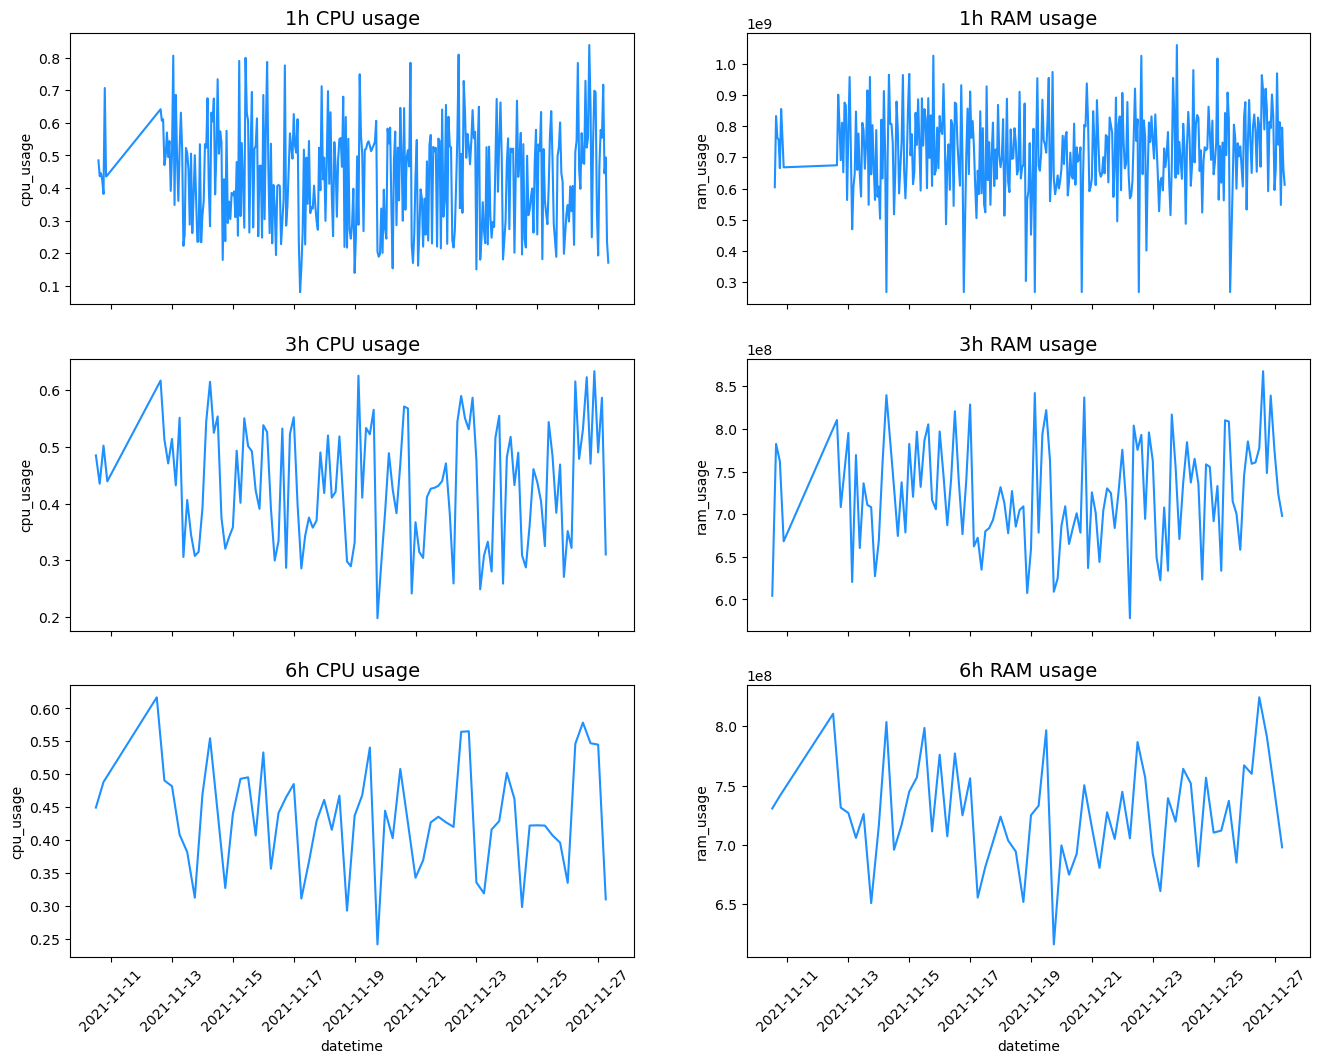

In [20]:
# downsampling changing frequency
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16,12))

# CPU usage
frequency = '1h'
resampled_df = df[['datetime','cpu_usage']].resample(frequency, on='datetime').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['datetime'], y=resampled_df['cpu_usage'], color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('{frequency} CPU usage'.format(frequency=frequency), fontsize=14)

frequency = '3h'
resampled_df = df[['datetime','cpu_usage']].resample(frequency, on='datetime').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['datetime'], y=resampled_df['cpu_usage'], color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('{frequency} CPU usage'.format(frequency=frequency), fontsize=14)

frequency = '6h'
resampled_df = df[['datetime','cpu_usage']].resample(frequency, on='datetime').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['datetime'], y=resampled_df['cpu_usage'], color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('{frequency} CPU usage'.format(frequency=frequency), fontsize=14)

# RAM usage
frequency = '1h'
resampled_df = df[['datetime','ram_usage']].resample(frequency, on='datetime').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['datetime'], y=resampled_df['ram_usage'], color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('{frequency} RAM usage'.format(frequency=frequency), fontsize=14)

frequency = '3h'
resampled_df = df[['datetime','ram_usage']].resample(frequency, on='datetime').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['datetime'], y=resampled_df['ram_usage'], color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('{frequency} RAM usage'.format(frequency=frequency), fontsize=14)

frequency = '6h'
resampled_df = df[['datetime','ram_usage']].resample(frequency, on='datetime').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['datetime'], y=resampled_df['ram_usage'], color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('{frequency} RAM usage'.format(frequency=frequency), fontsize=14)

ax[2, 0].tick_params(axis='x', rotation=45)
ax[2, 1].tick_params(axis='x', rotation=45)

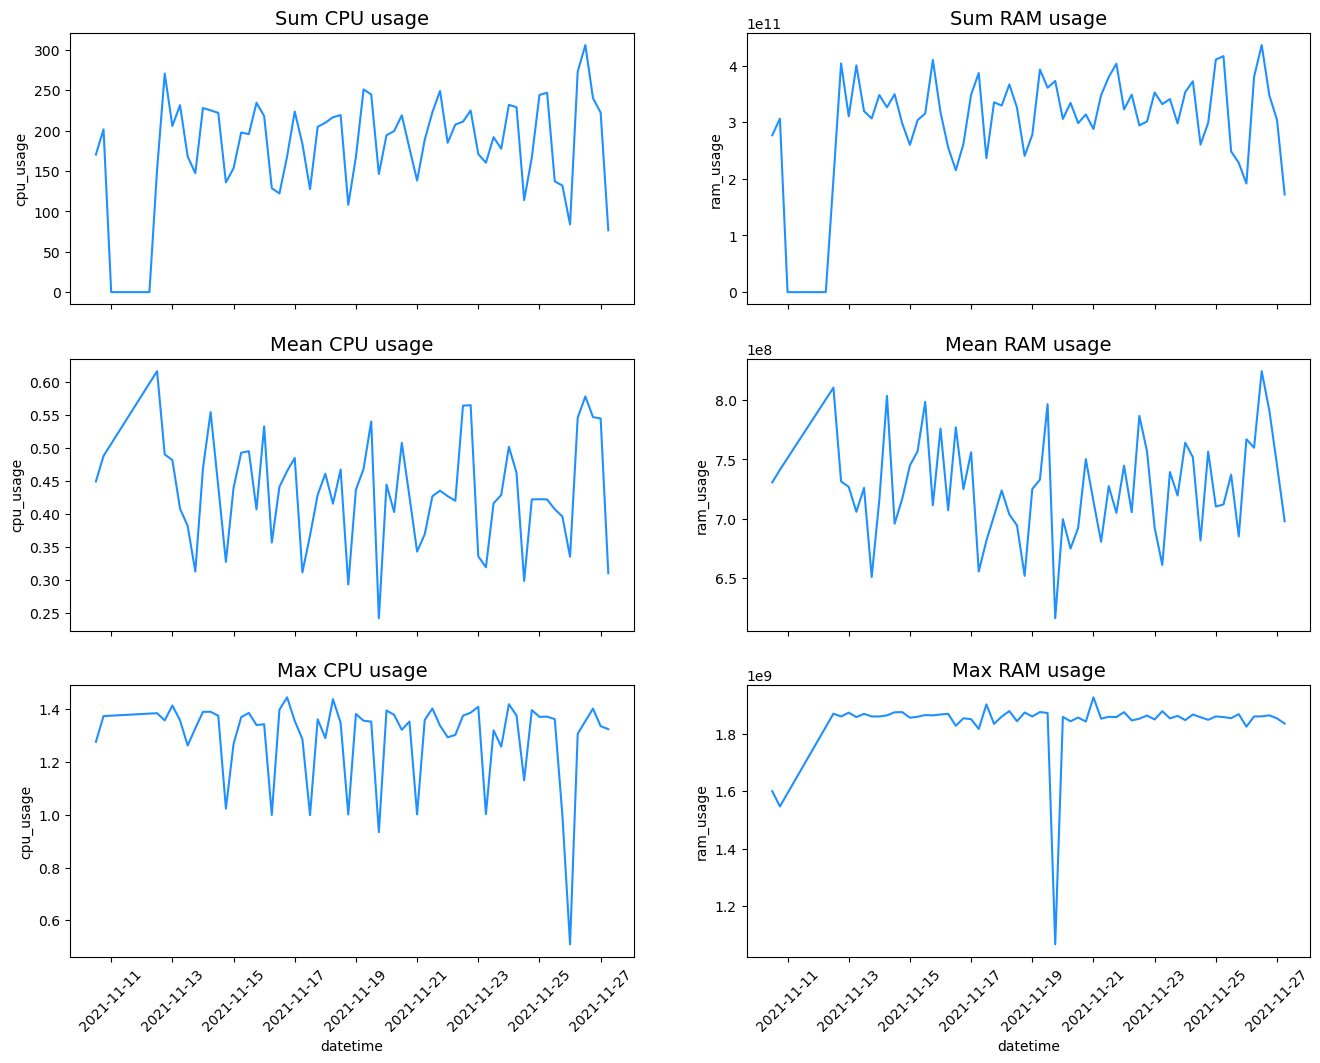

In [21]:
# downsampling to 6h changing the aggregation function
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16,12))
frequency = '6h'
plt.title('6h CPU and RAM usage with different aggregating functions')

# CPU usage
resampled_df = df[['datetime','cpu_usage']].resample(frequency, on='datetime').sum().reset_index(drop=False)
sns.lineplot(x=resampled_df['datetime'], y=resampled_df['cpu_usage'], color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('Sum CPU usage'.format(frequency=frequency), fontsize=14)

resampled_df = df[['datetime','cpu_usage']].resample(frequency, on='datetime').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['datetime'], y=resampled_df['cpu_usage'], color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('Mean CPU usage'.format(frequency=frequency), fontsize=14)

resampled_df = df[['datetime','cpu_usage']].resample(frequency, on='datetime').max().reset_index(drop=False)
sns.lineplot(x=resampled_df['datetime'], y=resampled_df['cpu_usage'], color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Max CPU usage'.format(frequency=frequency), fontsize=14)

# RAM usage
resampled_df = df[['datetime','ram_usage']].resample(frequency, on='datetime').sum().reset_index(drop=False)
sns.lineplot(x=resampled_df['datetime'], y=resampled_df['ram_usage'], color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Sum RAM usage'.format(frequency=frequency), fontsize=14)

resampled_df = df[['datetime','ram_usage']].resample(frequency, on='datetime').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['datetime'], y=resampled_df['ram_usage'], color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Mean RAM usage'.format(frequency=frequency), fontsize=14)

resampled_df = df[['datetime','ram_usage']].resample(frequency, on='datetime').max().reset_index(drop=False)
sns.lineplot(x=resampled_df['datetime'], y=resampled_df['ram_usage'], color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Max RAM usage'.format(frequency=frequency), fontsize=14)

# adjust x label rotation
ax[2, 0].tick_params(axis='x', rotation=45)
ax[2, 1].tick_params(axis='x', rotation=45)

Stationarity

In [22]:
frequency = '1h'
df_max = df[['datetime','cpu_usage', 'ram_usage']].resample(frequency, on='datetime').max().interpolate().ffill().reset_index(drop=False)
df_max


datetime  cpu_usage     ram_usage
0   2021-11-10 14:00:00   1.276808  1.130758e+09
1   2021-11-10 15:00:00   0.996645  1.559351e+09
2   2021-11-10 16:00:00   0.983066  1.494233e+09
3   2021-11-10 17:00:00   0.983279  1.600532e+09
4   2021-11-10 18:00:00   0.999460  1.010856e+09
..                  ...        ...           ...
398 2021-11-27 04:00:00   1.323356  1.753735e+09
399 2021-11-27 05:00:00   1.257932  1.023115e+09
400 2021-11-27 06:00:00   1.324840  1.836081e+09
401 2021-11-27 07:00:00   0.815902  9.785344e+08
402 2021-11-27 08:00:00   0.579697  8.333967e+08

[403 rows x 3 columns]

In [23]:
df_mean = df[['datetime','cpu_usage', 'ram_usage']].resample(frequency, on='datetime').mean().interpolate().ffill().reset_index(drop=False)
df_mean

datetime  cpu_usage     ram_usage
0   2021-11-10 14:00:00   0.484930  6.042414e+08
1   2021-11-10 15:00:00   0.436284  8.322325e+08
2   2021-11-10 16:00:00   0.445250  7.628180e+08
3   2021-11-10 17:00:00   0.424393  7.568162e+08
4   2021-11-10 18:00:00   0.381988  6.655290e+08
..                  ...        ...           ...
398 2021-11-27 04:00:00   0.717003  8.129647e+08
399 2021-11-27 05:00:00   0.445396  5.477123e+08
400 2021-11-27 06:00:00   0.493815  7.955776e+08
401 2021-11-27 07:00:00   0.234506  6.613086e+08
402 2021-11-27 08:00:00   0.170975  6.121102e+08

[403 rows x 3 columns]

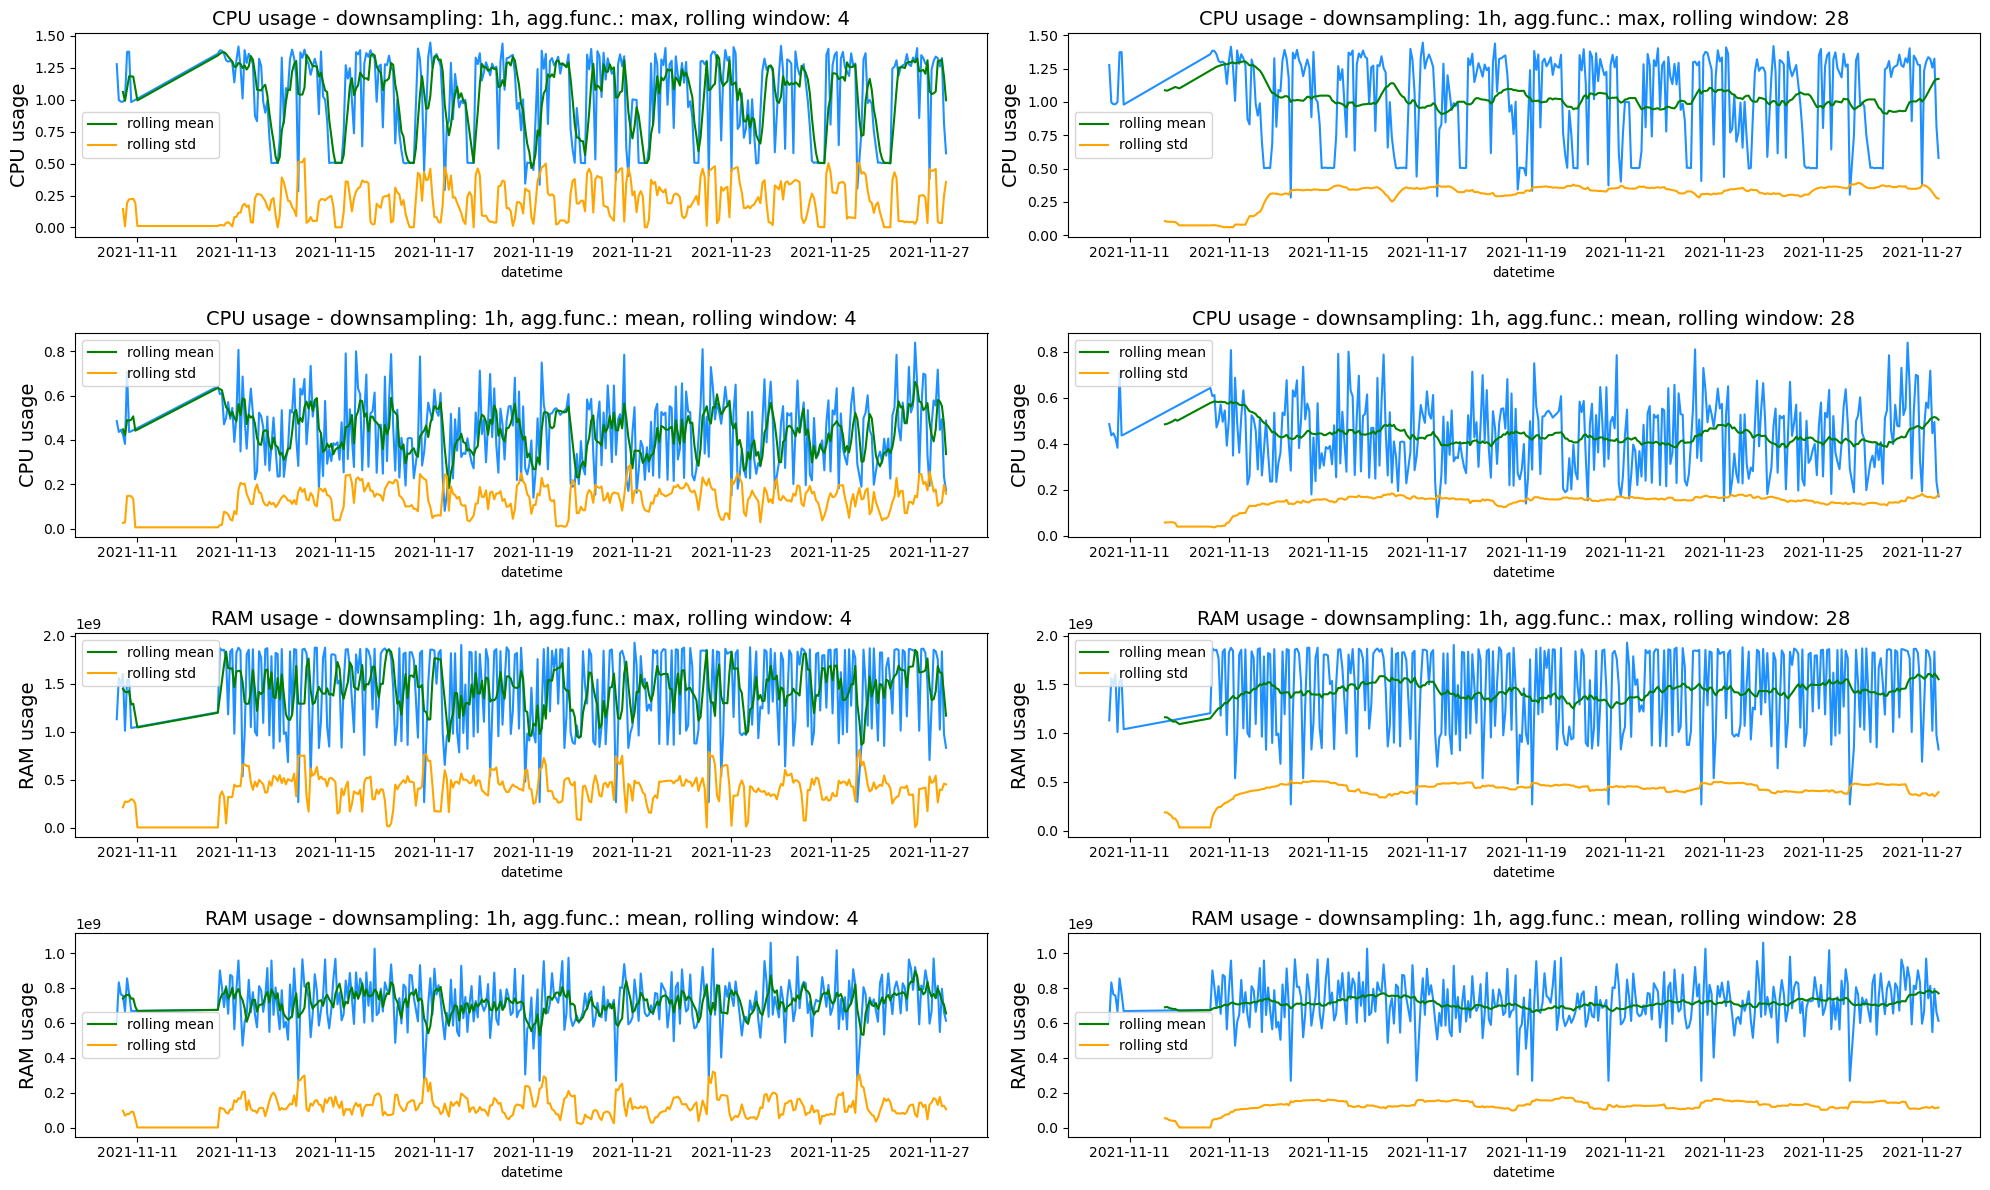

In [24]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 12))
plt.title('Stationarity')

############ CPU usage ############
# aggregation function: max
# 1d / 6h = 4 --> rolling window size
rolling_window = 4
sns.lineplot(x=df_max['datetime'], y=df_max['cpu_usage'], ax=ax[0,0], color='dodgerblue')
sns.lineplot(x=df_max['datetime'], y=df_max['cpu_usage'].rolling(rolling_window).mean(), ax=ax[0,0], color='green', label='rolling mean')
sns.lineplot(x=df_max['datetime'], y=df_max['cpu_usage'].rolling(rolling_window).std(), ax=ax[0,0], color='orange', label='rolling std')
ax[0,0].set_title('CPU usage - downsampling: {frequency}, agg.func.: max, rolling window: {rolling_window}'.format(rolling_window=rolling_window, frequency=frequency), fontsize=14)
ax[0,0].set_ylabel(ylabel='CPU usage', fontsize=14)

# 1w / 6h = 28 --> rolling window size
rolling_window = 28
sns.lineplot(x=df_max['datetime'], y=df_max['cpu_usage'], ax=ax[0,1], color='dodgerblue')
sns.lineplot(x=df_max['datetime'], y=df_max['cpu_usage'].rolling(rolling_window).mean(), ax=ax[0,1], color='green', label='rolling mean')
sns.lineplot(x=df_max['datetime'], y=df_max['cpu_usage'].rolling(rolling_window).std(), ax=ax[0,1], color='orange', label='rolling std')
ax[0,1].set_title('CPU usage - downsampling: {frequency}, agg.func.: max, rolling window: {rolling_window}'.format(rolling_window=rolling_window, frequency=frequency), fontsize=14)
ax[0,1].set_ylabel(ylabel='CPU usage', fontsize=14)

# aggregation function: mean
# 1d / 6h = 4 --> rolling window size
rolling_window = 4
sns.lineplot(x=df_mean['datetime'], y=df_mean['cpu_usage'], ax=ax[1,0], color='dodgerblue')
sns.lineplot(x=df_mean['datetime'], y=df_mean['cpu_usage'].rolling(rolling_window).mean(), ax=ax[1,0], color='green', label='rolling mean')
sns.lineplot(x=df_mean['datetime'], y=df_mean['cpu_usage'].rolling(rolling_window).std(), ax=ax[1,0], color='orange', label='rolling std')
ax[1,0].set_title('CPU usage - downsampling: {frequency}, agg.func.: mean, rolling window: {rolling_window}'.format(rolling_window=rolling_window, frequency=frequency), fontsize=14)
ax[1,0].set_ylabel(ylabel='CPU usage', fontsize=14)

# 1w / 6h = 28 --> rolling window size
rolling_window = 28
sns.lineplot(x=df_mean['datetime'], y=df_mean['cpu_usage'], ax=ax[1,1], color='dodgerblue')
sns.lineplot(x=df_mean['datetime'], y=df_mean['cpu_usage'].rolling(rolling_window).mean(), ax=ax[1,1], color='green', label='rolling mean')
sns.lineplot(x=df_mean['datetime'], y=df_mean['cpu_usage'].rolling(rolling_window).std(), ax=ax[1,1], color='orange', label='rolling std')
ax[1,1].set_title('CPU usage - downsampling: {frequency}, agg.func.: mean, rolling window: {rolling_window}'.format(rolling_window=rolling_window, frequency=frequency), fontsize=14)
ax[1,1].set_ylabel(ylabel='CPU usage', fontsize=14)

############ RAM usage ############
# aggregation function: max
# 1d / 6h = 4 --> rolling window size
rolling_window = 4
sns.lineplot(x=df_max['datetime'], y=df_max['ram_usage'], ax=ax[2,0], color='dodgerblue')
sns.lineplot(x=df_max['datetime'], y=df_max['ram_usage'].rolling(rolling_window).mean(), ax=ax[2,0], color='green', label='rolling mean')
sns.lineplot(x=df_max['datetime'], y=df_max['ram_usage'].rolling(rolling_window).std(), ax=ax[2,0], color='orange', label='rolling std')
ax[2,0].set_title('RAM usage - downsampling: {frequency}, agg.func.: max, rolling window: {rolling_window}'.format(rolling_window=rolling_window, frequency=frequency), fontsize=14)
ax[2,0].set_ylabel(ylabel='RAM usage', fontsize=14)

# 1w / 6h = 28 --> rolling window size
rolling_window = 28
sns.lineplot(x=df_max['datetime'], y=df_max['ram_usage'], ax=ax[2,1], color='dodgerblue')
sns.lineplot(x=df_max['datetime'], y=df_max['ram_usage'].rolling(rolling_window).mean(), ax=ax[2,1], color='green', label='rolling mean')
sns.lineplot(x=df_max['datetime'], y=df_max['ram_usage'].rolling(rolling_window).std(), ax=ax[2,1], color='orange', label='rolling std')
ax[2,1].set_title('RAM usage - downsampling: {frequency}, agg.func.: max, rolling window: {rolling_window}'.format(rolling_window=rolling_window, frequency=frequency), fontsize=14)
ax[2,1].set_ylabel(ylabel='RAM usage', fontsize=14)

# aggregation function: mean
# 1d / 6h = 4 --> rolling window size
rolling_window = 4
sns.lineplot(x=df_mean['datetime'], y=df_mean['ram_usage'], ax=ax[3,0], color='dodgerblue')
sns.lineplot(x=df_mean['datetime'], y=df_mean['ram_usage'].rolling(rolling_window).mean(), ax=ax[3,0], color='green', label='rolling mean')
sns.lineplot(x=df_mean['datetime'], y=df_mean['ram_usage'].rolling(rolling_window).std(), ax=ax[3,0], color='orange', label='rolling std')
ax[3,0].set_title('RAM usage - downsampling: {frequency}, agg.func.: mean, rolling window: {rolling_window}'.format(rolling_window=rolling_window, frequency=frequency), fontsize=14)
ax[3,0].set_ylabel(ylabel='RAM usage', fontsize=14)

# 1w / 6h = 28 --> rolling window size
rolling_window = 28
sns.lineplot(x=df_mean['datetime'], y=df_mean['ram_usage'], ax=ax[3,1], color='dodgerblue')
sns.lineplot(x=df_mean['datetime'], y=df_mean['ram_usage'].rolling(rolling_window).mean(), ax=ax[3,1], color='green', label='rolling mean')
sns.lineplot(x=df_mean['datetime'], y=df_mean['ram_usage'].rolling(rolling_window).std(), ax=ax[3,1], color='orange', label='rolling std')
ax[3,1].set_title('RAM usage - downsampling: {frequency}, agg.func.: mean, rolling window: {rolling_window}'.format(rolling_window=rolling_window, frequency=frequency), fontsize=14)
ax[3,1].set_ylabel(ylabel='RAM usage', fontsize=14)

plt.tight_layout()
plt.show()

I choose df_max for subsequent tests

In [27]:
df_max['year'] = pd.DatetimeIndex(df_max['datetime']).year
df_max['month'] = pd.DatetimeIndex(df_max['datetime']).month
df_max['day'] = pd.DatetimeIndex(df_max['datetime']).day
df_max['day_of_year'] = pd.DatetimeIndex(df_max['datetime']).dayofyear
df_max['season'] = df_max['month'] % 12 // 3 + 1

df_max[['datetime', 'year', 'month', 'day', 'day_of_year', 'season']]

datetime  year  month  day  day_of_year  season
0   2021-11-10 14:00:00  2021     11   10          314       4
1   2021-11-10 15:00:00  2021     11   10          314       4
2   2021-11-10 16:00:00  2021     11   10          314       4
3   2021-11-10 17:00:00  2021     11   10          314       4
4   2021-11-10 18:00:00  2021     11   10          314       4
..                  ...   ...    ...  ...          ...     ...
398 2021-11-27 04:00:00  2021     11   27          331       4
399 2021-11-27 05:00:00  2021     11   27          331       4
400 2021-11-27 06:00:00  2021     11   27          331       4
401 2021-11-27 07:00:00  2021     11   27          331       4
402 2021-11-27 08:00:00  2021     11   27          331       4

[403 rows x 6 columns]

Check for seasonality

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'cpu_usage', 'ram_usage'
]

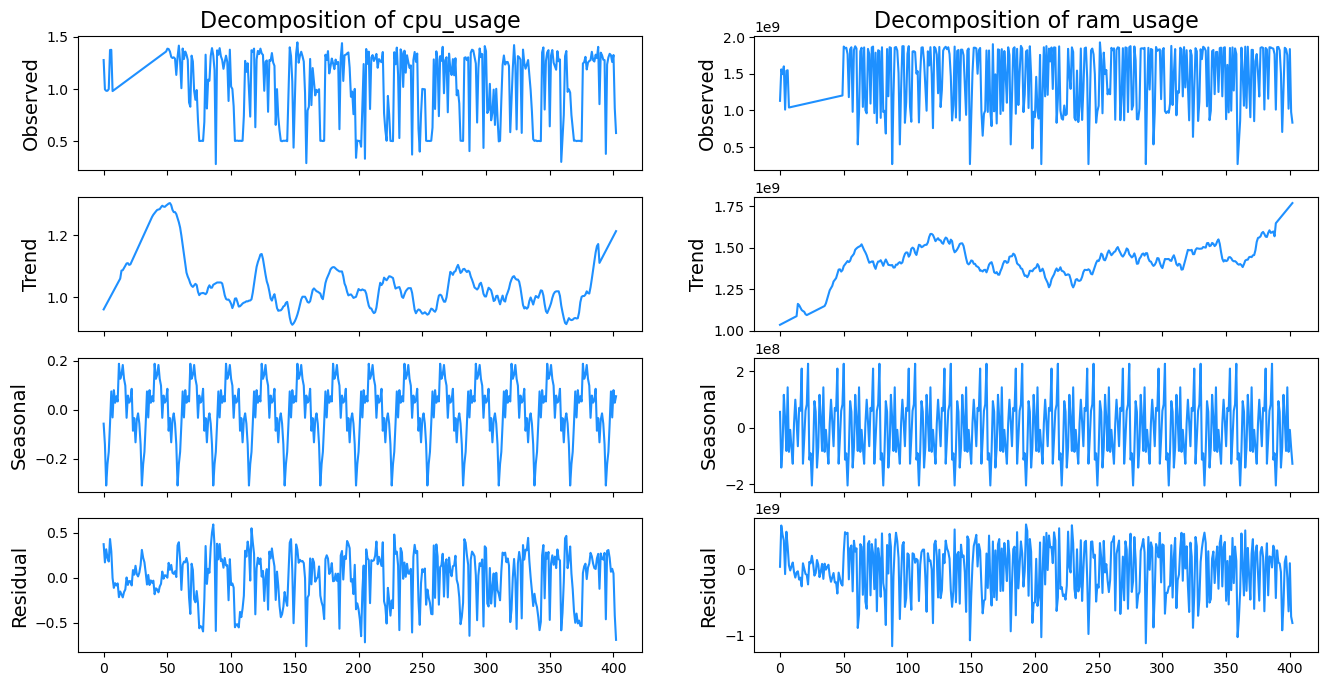

In [29]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['cpu_usage', 'ram_usage']):
    
    res = seasonal_decompose(df_max[column], period=28, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue') # the original or input time series
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue') # the long-term movement or direction of the data
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue') # the repeated or cyclical patterns in the data
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue') # the part of the data that cannot be explained by the other components
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

Correlation

In [31]:
frequency = '1h'
df_max = df.drop(['human_date', 'time'], axis=1).resample(frequency, on='datetime').max().interpolate().ffill().reset_index(drop=False)

df_max['year'] = pd.DatetimeIndex(df_max['datetime']).year
df_max['month'] = pd.DatetimeIndex(df_max['datetime']).month
df_max['day'] = pd.DatetimeIndex(df_max['datetime']).day
df_max['day_of_year'] = pd.DatetimeIndex(df_max['datetime']).dayofyear
df_max['season'] = df_max['month'] % 12 // 3 + 1
df_max


C:\Users\Alice Piemonti\AppData\Local\Temp\ipykernel_12152\2523678753.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_max = df.drop(['human_date', 'time'], axis=1).resample(frequency, on='datetime').max().interpolate().ffill().reset_index(drop=False)


datetime ram_limit  cpu_limit     ram_usage  cpu_usage      n  \
0   2021-11-10 14:00:00     2048M        2.0  1.130758e+09   1.276808  500.0   
1   2021-11-10 15:00:00     2048M        2.0  1.559351e+09   0.996645  460.0   
2   2021-11-10 16:00:00     2048M        2.0  1.494233e+09   0.983066  480.0   
3   2021-11-10 17:00:00     2048M        2.0  1.600532e+09   0.983279  480.0   
4   2021-11-10 18:00:00     2048M        2.0  1.010856e+09   0.999460  440.0   
..                  ...       ...        ...           ...        ...    ...   
398 2021-11-27 04:00:00      768M        2.0  1.753735e+09   1.323356  550.0   
399 2021-11-27 05:00:00      768M        2.0  1.023115e+09   1.257932  550.0   
400 2021-11-27 06:00:00     3840M        1.5  1.836081e+09   1.324840  550.0   
401 2021-11-27 07:00:00      768M        1.5  9.785344e+08   0.815902  190.0   
402 2021-11-27 08:00:00     4096M        1.0  8.333967e+08   0.579697  120.0   

           mean       lat50       lat75       lat80  ...       lat95  \
0    60398090.0  60414274.0  60683893.0  60710399.0  ...  60792898.0   
1    93936583.0  94259814.0  94594380.0  94773325.0  ...  94899446.0   
2    95931083.0  96020918.0  96603277.0  96698981.0  ...  96893427.0   
3    97132575.0  97360300.0  97554677.0  97658707.0  ...  97770943.0   
4    97207925.0  97417298.0  97850268.0  97935299.0  ...  98056113.0   
..          ...         ...         ...         ...  ...         ...   
398  98065398.0  98048590.0  98325506.0  98369522.0  ...  98511735.0   
399  98199627.0  98221357.0  98449154.0  98506916.0  ...  98655810.0   
400  96423698.0  96467143.0  96866991.0  96897590.0  ...  97014310.0   
401  15800009.0  15788169.0  15855969.0  15871610.0  ...  15907272.0   
402   4243770.0   4414612.0   4534455.0   4537277.0  ...   4614778.0   

          lat98       lat99      lat100  delta  year  month  day  day_of_year  \
0    60796880.0  60797375.0  60810918.0  295.0  2021     11   10          314   
1    94957543.0  94958607.0  94962118.0  599.0  2021     11   10          314   
2    96975504.0  96982968.0  96997842.0  401.0  2021     11   10          314   
3    97786956.0  97788483.0  97801438.0  398.0  2021     11   10          314   
4    98116328.0  98117312.0  98118998.0  207.0  2021     11   10          314   
..          ...         ...         ...    ...   ...    ...  ...          ...   
398  98524678.0  98527532.0  99352575.0  712.0  2021     11   27          331   
399  98673755.0  98678868.0  98705062.0  725.0  2021     11   27          331   
400  97066600.0  97070644.0  97092848.0  715.0  2021     11   27          331   
401  15908656.0  15908841.0  15911875.0  219.0  2021     11   27          331   
402   4616102.0   4616678.0   4633962.0  216.0  2021     11   27          331   

     season  
0         4  
1         4  
2         4  
3         4  
4         4  
..      ...  
398       4  
399       4  
400       4  
401       4  
402       4  

[403 rows x 21 columns]

In [32]:
df_max = df_max.drop(['month', 'day_of_year', 'season', 'year'], axis=1)
df_max

datetime ram_limit  cpu_limit     ram_usage  cpu_usage      n  \
0   2021-11-10 14:00:00     2048M        2.0  1.130758e+09   1.276808  500.0   
1   2021-11-10 15:00:00     2048M        2.0  1.559351e+09   0.996645  460.0   
2   2021-11-10 16:00:00     2048M        2.0  1.494233e+09   0.983066  480.0   
3   2021-11-10 17:00:00     2048M        2.0  1.600532e+09   0.983279  480.0   
4   2021-11-10 18:00:00     2048M        2.0  1.010856e+09   0.999460  440.0   
..                  ...       ...        ...           ...        ...    ...   
398 2021-11-27 04:00:00      768M        2.0  1.753735e+09   1.323356  550.0   
399 2021-11-27 05:00:00      768M        2.0  1.023115e+09   1.257932  550.0   
400 2021-11-27 06:00:00     3840M        1.5  1.836081e+09   1.324840  550.0   
401 2021-11-27 07:00:00      768M        1.5  9.785344e+08   0.815902  190.0   
402 2021-11-27 08:00:00     4096M        1.0  8.333967e+08   0.579697  120.0   

           mean       lat50       lat75       lat80       lat90       lat95  \
0    60398090.0  60414274.0  60683893.0  60710399.0  60783835.0  60792898.0   
1    93936583.0  94259814.0  94594380.0  94773325.0  94861770.0  94899446.0   
2    95931083.0  96020918.0  96603277.0  96698981.0  96798066.0  96893427.0   
3    97132575.0  97360300.0  97554677.0  97658707.0  97753512.0  97770943.0   
4    97207925.0  97417298.0  97850268.0  97935299.0  98041669.0  98056113.0   
..          ...         ...         ...         ...         ...         ...   
398  98065398.0  98048590.0  98325506.0  98369522.0  98495184.0  98511735.0   
399  98199627.0  98221357.0  98449154.0  98506916.0  98628481.0  98655810.0   
400  96423698.0  96467143.0  96866991.0  96897590.0  96982385.0  97014310.0   
401  15800009.0  15788169.0  15855969.0  15871610.0  15886851.0  15907272.0   
402   4243770.0   4414612.0   4534455.0   4537277.0   4564669.0   4614778.0   

          lat98       lat99      lat100  delta  day  
0    60796880.0  60797375.0  60810918.0  295.0   10  
1    94957543.0  94958607.0  94962118.0  599.0   10  
2    96975504.0  96982968.0  96997842.0  401.0   10  
3    97786956.0  97788483.0  97801438.0  398.0   10  
4    98116328.0  98117312.0  98118998.0  207.0   10  
..          ...         ...         ...    ...  ...  
398  98524678.0  98527532.0  99352575.0  712.0   27  
399  98673755.0  98678868.0  98705062.0  725.0   27  
400  97066600.0  97070644.0  97092848.0  715.0   27  
401  15908656.0  15908841.0  15911875.0  219.0   27  
402   4616102.0   4616678.0   4633962.0  216.0   27  

[403 rows x 17 columns]

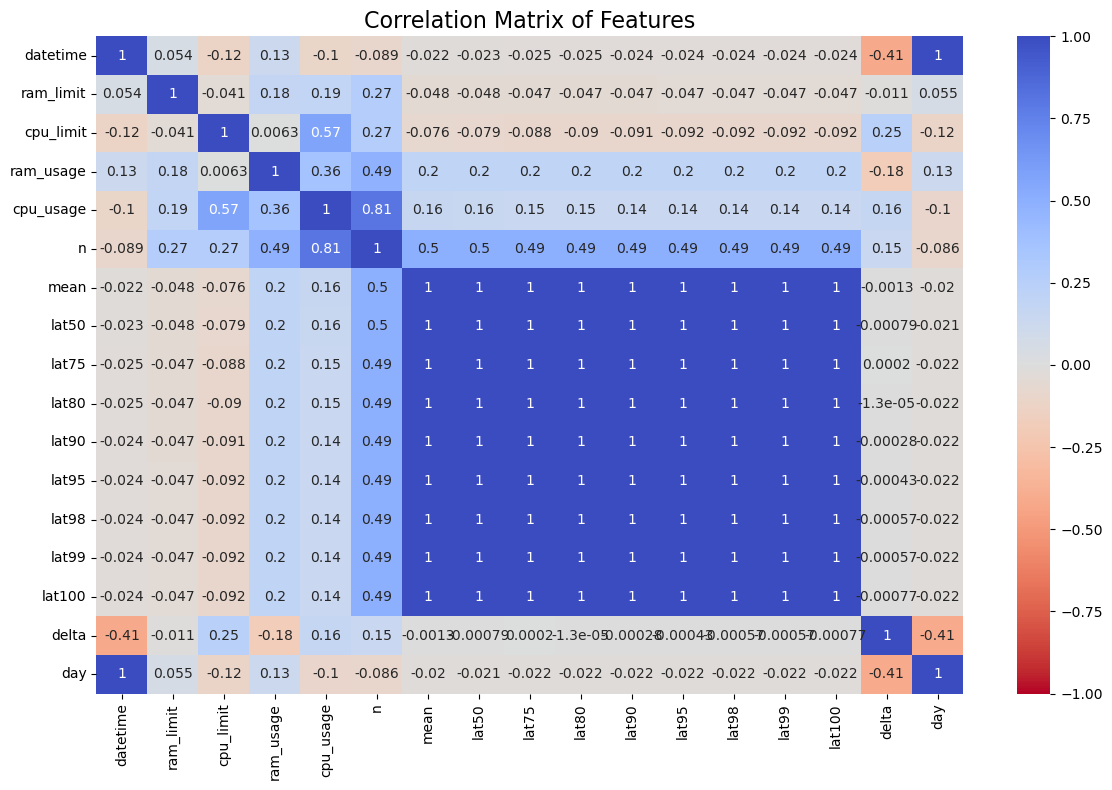

In [34]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

df_max["ram_limit"] = df_max["ram_limit"].str.replace('M', '').astype(int)
corrmat = df_max.corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax)
ax.set_title('Correlation Matrix of Features', fontsize=16)

plt.tight_layout()
plt.show()

In [35]:
core_columns = ['cpu_usage', 'ram_usage']
df_max_core = df_max[core_columns].copy()
for column in core_columns:
    decomp = seasonal_decompose(df_max_core[column], period=28, model='additive', extrapolate_trend='freq')
    df_max_core[f"{column}_trend"] = decomp.trend
    df_max_core[f"{column}_seasonal"] = decomp.seasonal
df_max_core

cpu_usage     ram_usage  cpu_usage_trend  cpu_usage_seasonal  \
0     1.276808  1.130758e+09         0.960700           -0.057323   
1     0.996645  1.559351e+09         0.968365           -0.142706   
2     0.983066  1.494233e+09         0.976031           -0.309756   
3     0.983279  1.600532e+09         0.983696           -0.222584   
4     0.999460  1.010856e+09         0.991361           -0.172527   
..         ...           ...              ...                 ...   
398   1.323356  1.753735e+09         1.182002            0.074241   
399   1.257932  1.023115e+09         1.189892           -0.031991   
400   1.324840  1.836081e+09         1.197781            0.079353   
401   0.815902  9.785344e+08         1.205670            0.028040   
402   0.579697  8.333967e+08         1.213560            0.054519   

     ram_usage_trend  ram_usage_seasonal  
0       1.035588e+09        5.691989e+07  
1       1.039594e+09       -1.404651e+08  
2       1.043601e+09       -6.913597e+07  
3       1.047607e+09        1.172650e+08  
4       1.051613e+09        3.118644e+07  
..               ...                 ...  
398     1.732091e+09        1.438631e+08  
399     1.741437e+09       -8.474959e+07  
400     1.750783e+09       -6.704071e+06  
401     1.760130e+09       -7.021903e+07  
402     1.769476e+09       -1.269867e+08  

[403 rows x 6 columns]

In [36]:
days_in_week = 7

for column in core_columns:
    df_max_core[f'{column}_seasonal_shift_b_2w'] = df_max_core[f'{column}_seasonal'].shift(-2 * days_in_week)
    df_max_core[f'{column}_seasonal_shift_b_1w'] = df_max_core[f'{column}_seasonal'].shift(-1 * days_in_week)
    df_max_core[f'{column}_seasonal_shift_1w'] = df_max_core[f'{column}_seasonal'].shift(1 * days_in_week)
    df_max_core[f'{column}_seasonal_shift_2w'] = df_max_core[f'{column}_seasonal'].shift(2 * days_in_week)
    df_max_core[f'{column}_seasonal_shift_3w'] = df_max_core[f'{column}_seasonal'].shift(3 * days_in_week)

    df_max_core[f'{column}_seasonal_shift_1d'] = df_max_core[f'{column}_seasonal'].shift(1)
    df_max_core[f'{column}_seasonal_shift_2d'] = df_max_core[f'{column}_seasonal'].shift(2)
    df_max_core[f'{column}_seasonal_shift_3d'] = df_max_core[f'{column}_seasonal'].shift(3)
    df_max_core[f'{column}_seasonal_shift_4d'] = df_max_core[f'{column}_seasonal'].shift(4)
    df_max_core[f'{column}_seasonal_shift_5d'] = df_max_core[f'{column}_seasonal'].shift(5)
    df_max_core[f'{column}_seasonal_shift_6d'] = df_max_core[f'{column}_seasonal'].shift(6)
df_max_core

cpu_usage     ram_usage  cpu_usage_trend  cpu_usage_seasonal  \
0     1.276808  1.130758e+09         0.960700           -0.057323   
1     0.996645  1.559351e+09         0.968365           -0.142706   
2     0.983066  1.494233e+09         0.976031           -0.309756   
3     0.983279  1.600532e+09         0.983696           -0.222584   
4     0.999460  1.010856e+09         0.991361           -0.172527   
..         ...           ...              ...                 ...   
398   1.323356  1.753735e+09         1.182002            0.074241   
399   1.257932  1.023115e+09         1.189892           -0.031991   
400   1.324840  1.836081e+09         1.197781            0.079353   
401   0.815902  9.785344e+08         1.205670            0.028040   
402   0.579697  8.333967e+08         1.213560            0.054519   

     ram_usage_trend  ram_usage_seasonal  cpu_usage_seasonal_shift_b_2w  \
0       1.035588e+09        5.691989e+07                       0.142076   
1       1.039594e+09       -1.404651e+08                       0.182179   
2       1.043601e+09       -6.913597e+07                       0.125410   
3       1.047607e+09        1.172650e+08                       0.097863   
4       1.051613e+09        3.118644e+07                      -0.033496   
..               ...                 ...                            ...   
398     1.732091e+09        1.438631e+08                            NaN   
399     1.741437e+09       -8.474959e+07                            NaN   
400     1.750783e+09       -6.704071e+06                            NaN   
401     1.760130e+09       -7.021903e+07                            NaN   
402     1.769476e+09       -1.269867e+08                            NaN   

     cpu_usage_seasonal_shift_b_1w  cpu_usage_seasonal_shift_1w  \
0                        -0.031991                          NaN   
1                         0.079353                          NaN   
2                         0.028040                          NaN   
3                         0.054519                          NaN   
4                         0.033272                          NaN   
..                             ...                          ...   
398                            NaN                    -0.015432   
399                            NaN                    -0.057323   
400                            NaN                    -0.142706   
401                            NaN                    -0.309756   
402                            NaN                    -0.222584   

     cpu_usage_seasonal_shift_2w  ...  ram_usage_seasonal_shift_b_1w  \
0                            NaN  ...                  -8.474959e+07   
1                            NaN  ...                  -6.704071e+06   
2                            NaN  ...                  -7.021903e+07   
3                            NaN  ...                  -1.269867e+08   
4                            NaN  ...                   1.598026e+07   
..                           ...  ...                            ...   
398                     0.028412  ...                            NaN   
399                     0.038219  ...                            NaN   
400                     0.084937  ...                            NaN   
401                    -0.086289  ...                            NaN   
402                    -0.034709  ...                            NaN   

     ram_usage_seasonal_shift_1w  ram_usage_seasonal_shift_2w  \
0                            NaN                          NaN   
1                            NaN                          NaN   
2                            NaN                          NaN   
3                            NaN                          NaN   
4                            NaN                          NaN   
..                           ...                          ...   
398                 9.492267e+07                 6.077338e+07   
399                 5.691989e+07                 8.340419e+07   
400                -

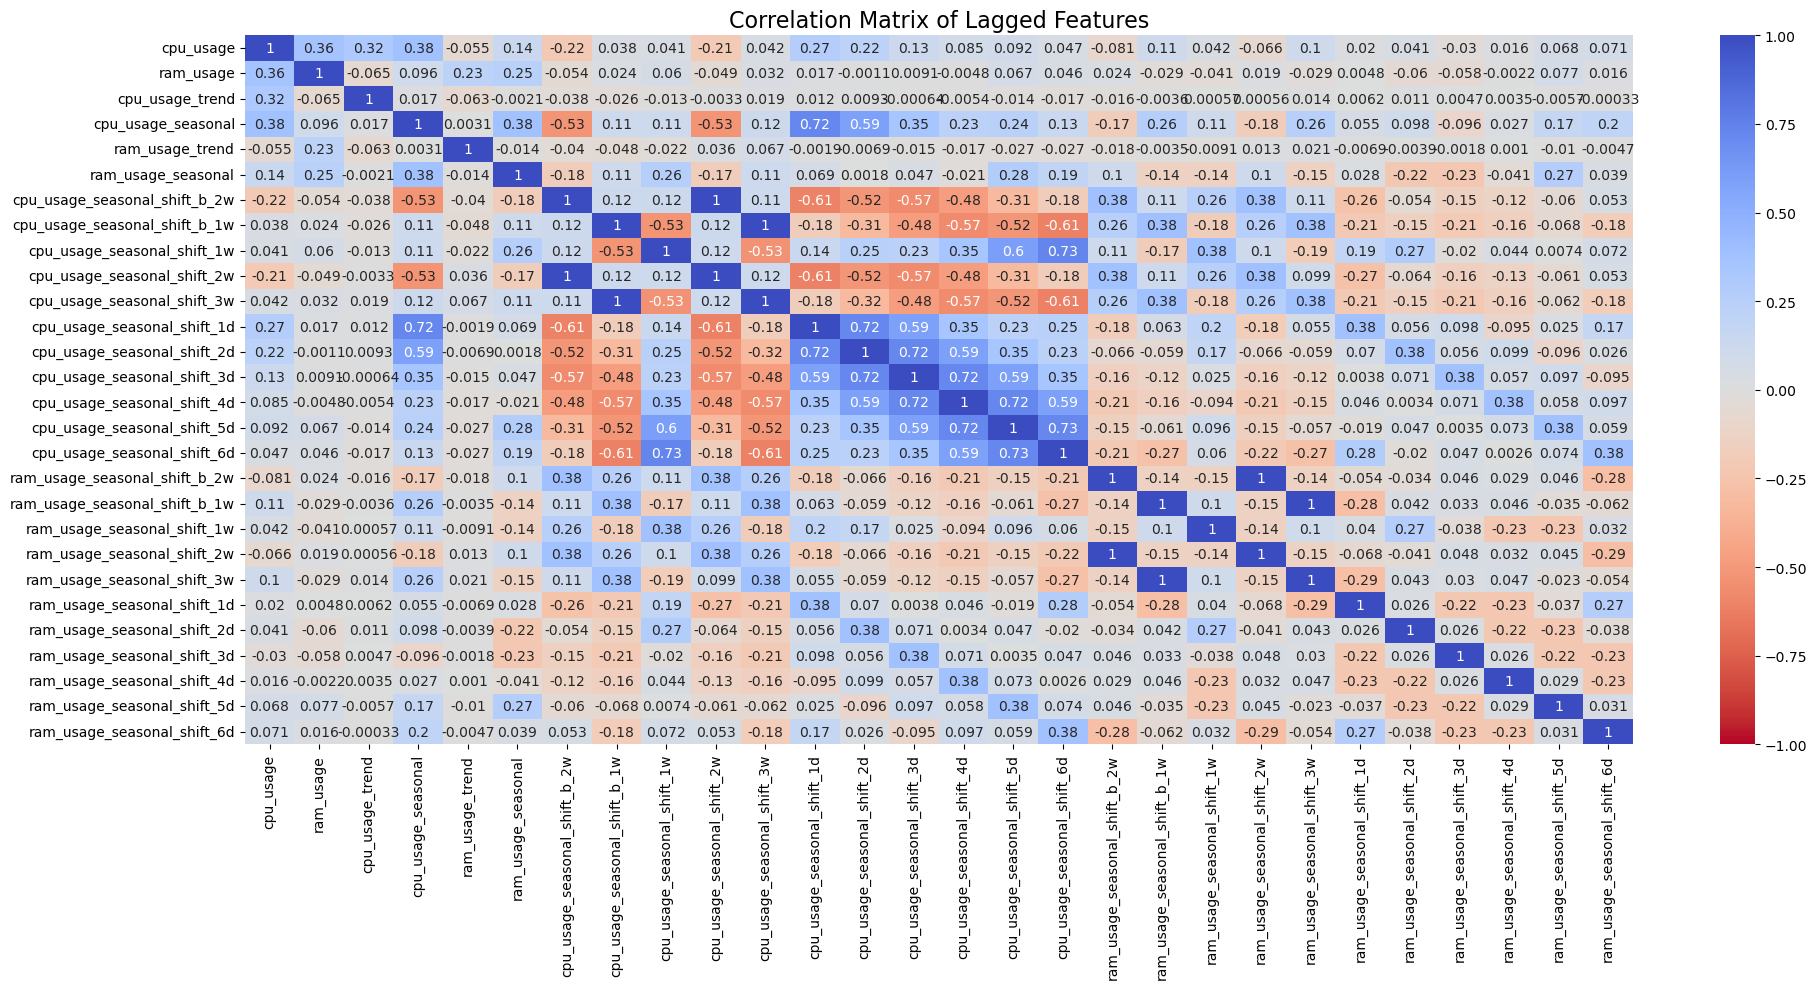

In [37]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

corrmat = df_max_core.corr()
sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax)
ax.set_title('Correlation Matrix of Lagged Features', fontsize=16)

plt.tight_layout()
plt.show()

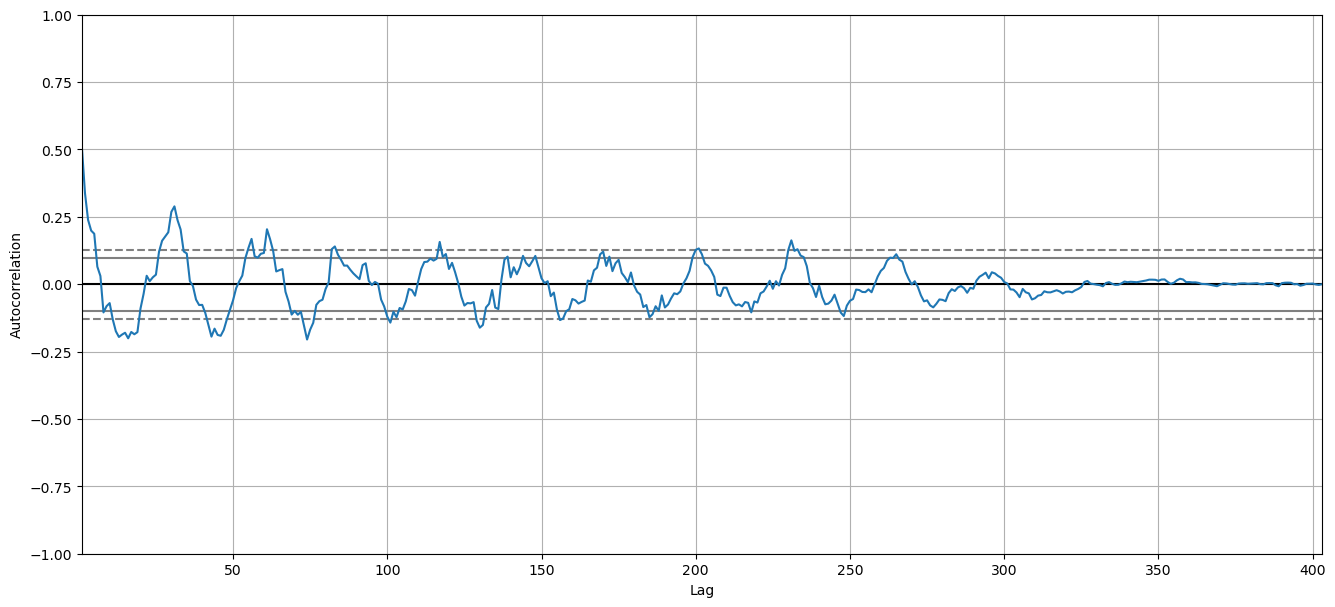

In [38]:
# autocorrelation CPU usage
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,7))

autocorrelation_plot(df_max['cpu_usage'])
plt.show()

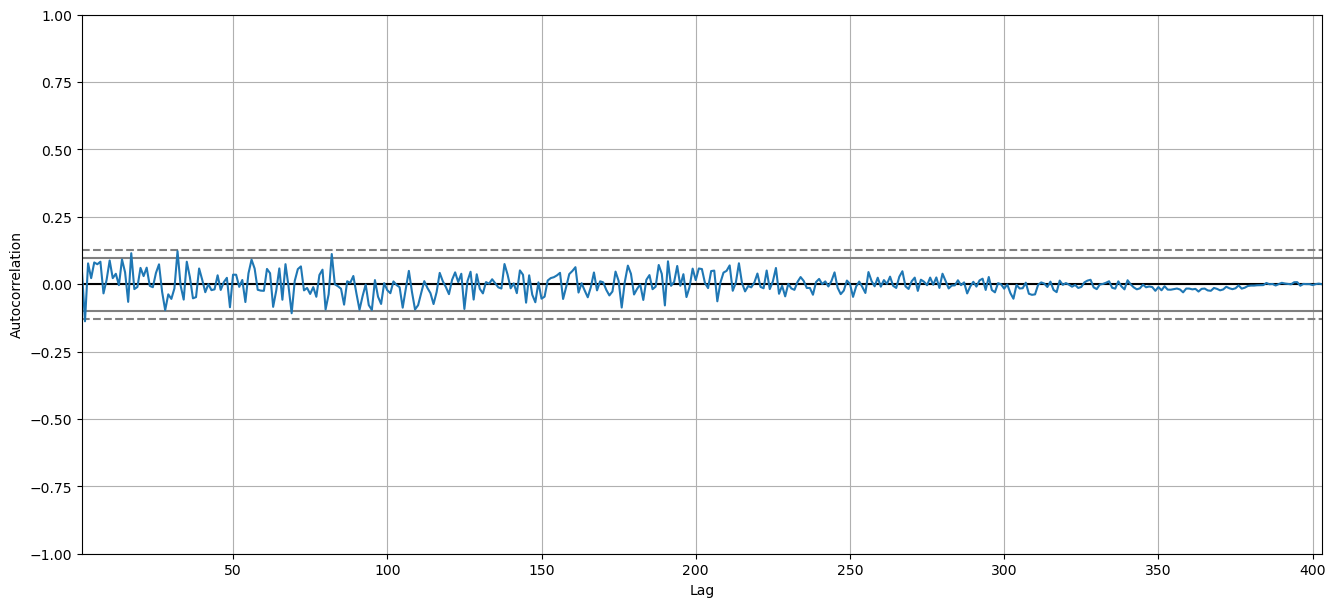

In [39]:
# autocorrelation RAM usage
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,7))

autocorrelation_plot(df_max['ram_usage'])
plt.show()

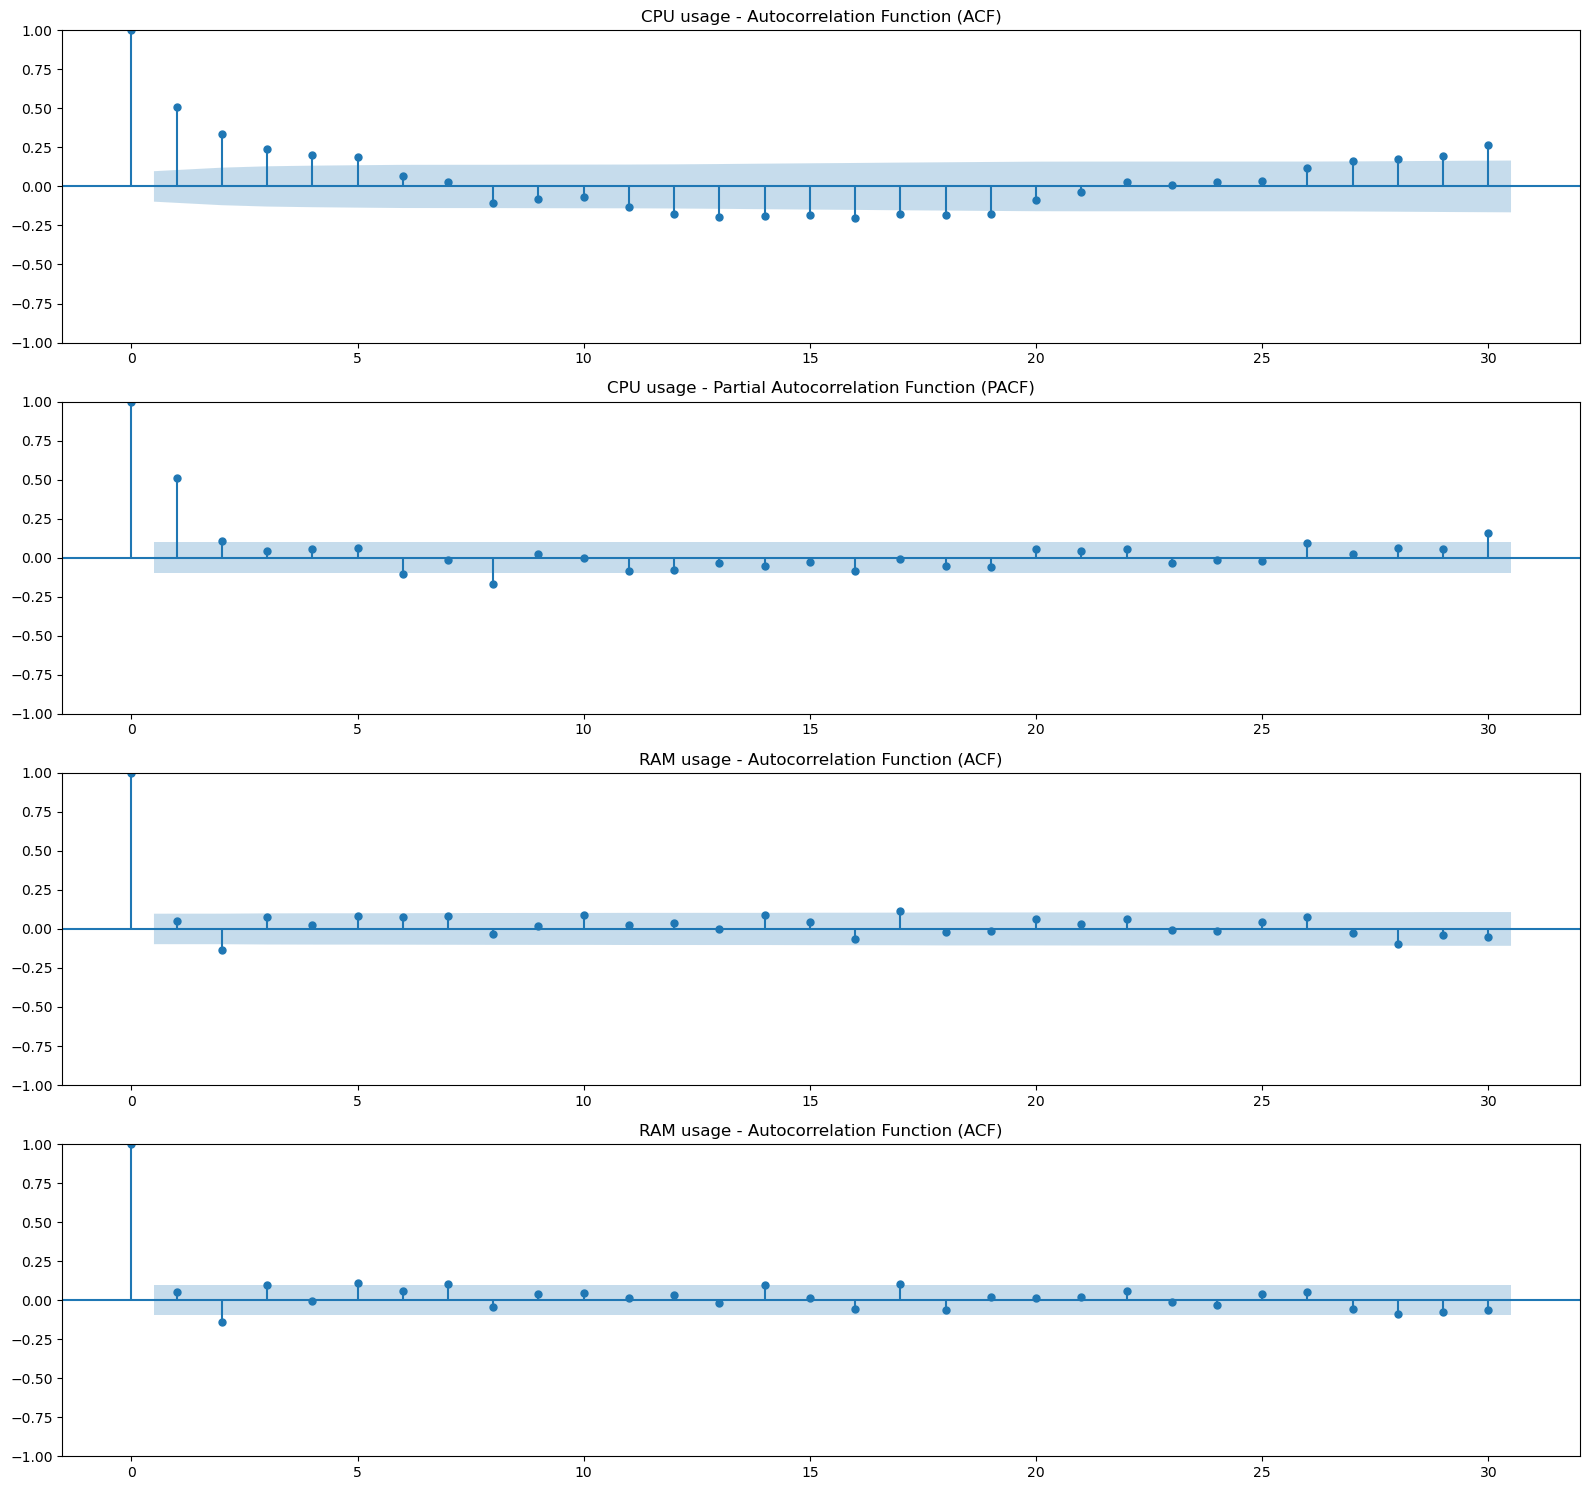

In [40]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(16, 15))
max_lag = 30

# Plot ACF on the CPU usage subplot
plot_acf(df_max['cpu_usage'], lags=max_lag, ax=ax[0])
ax[0].set_title('CPU usage - Autocorrelation Function (ACF)')

# Plot PACF on the CPU usage subplot
plot_pacf(df_max['cpu_usage'], lags=max_lag, ax=ax[1])
ax[1].set_title('CPU usage - Partial Autocorrelation Function (PACF)')

# Plot ACF on the RAM usage subplot
plot_acf(df_max['ram_usage'], lags=max_lag, ax=ax[2])
ax[2].set_title('RAM usage - Autocorrelation Function (ACF)')

# Plot PACF on the RAM usage subplot
plot_pacf(df_max['ram_usage'], lags=max_lag, ax=ax[3])
ax[3].set_title('RAM usage - Autocorrelation Function (ACF)')

plt.tight_layout()
plt.show()

The graphs show that there can be a (minimal) autocorrelation for CPU usage at lag 5. The same with RAM usage at lag 1

Outliers

In [41]:
# Function to remove outliers using IQR
def remove_outliers_iqr(df, column, threshold=5.5):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply the function to each column
for column in df_max[['cpu_usage']].columns:
    df_max_no_outliers = remove_outliers_iqr(df_max, column)

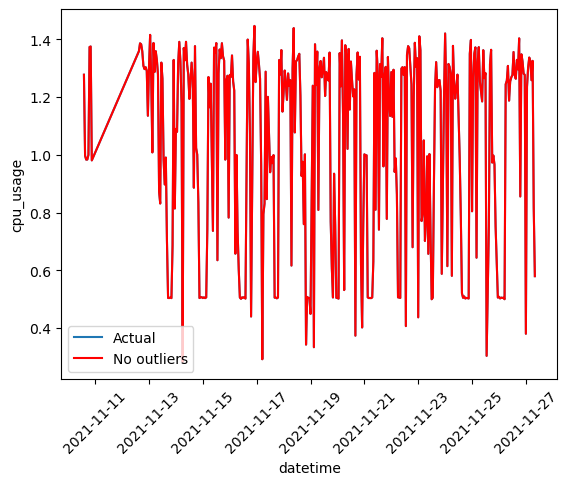

In [42]:
plt.plot(df_max[['datetime', 'cpu_usage']].set_index('datetime'))
plt.plot(df_max_no_outliers[['datetime', 'cpu_usage']].set_index('datetime'), color='red')
plt.xlabel('datetime')
plt.ylabel('cpu_usage')
plt.legend(['Actual', 'No outliers'])
plt.xticks(rotation=45)
plt.show()

## Univariate time series forecasting

In [43]:
train_size = int(0.85 * len(df_max))
test_size = len(df_max) - train_size

univariate_cpu_usage_df = df_max_no_outliers[['datetime', 'cpu_usage']].copy()
univariate_cpu_usage_df.columns = ['ds', 'y']

train_cpu_usage = univariate_cpu_usage_df.iloc[:train_size, :]

x_train_cpu_usage, y_train_cpu_usage = pd.DataFrame(univariate_cpu_usage_df.iloc[:train_size, 0]), pd.DataFrame(univariate_cpu_usage_df.iloc[:train_size, 1])
x_valid_cpu_usage, y_valid_cpu_usage = pd.DataFrame(univariate_cpu_usage_df.iloc[train_size:, 0]), pd.DataFrame(univariate_cpu_usage_df.iloc[train_size:, 1])

# univariate_ram_usage_df = df_max[['datetime', 'ram_usage']].copy()
# univariate_ram_usage_df.columns = ['ds', 'y']

print(len(train_cpu_usage), len(x_valid_cpu_usage))

342 61


# ARIMA
- Step 1: **check stationarity**: If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.
- Step 2: **difference**: If the time series is not stationary, it needs to be stationarized through differencing. Take the first difference, then check for stationarity. Take as many differences as it takes. Make sure you check seasonal differencing as well.
- Step 3: **filter out a validation sample**: This will be used to validate how accurate our model is. Use train test validation split to achieve this
- Step 4: **select AR and MA terms**: Use the ACF and PACF to decide whether to include an AR term(s), MA term(s), or both.
- Step 5: **build the model**: Build the model and set the number of periods to forecast to N (depends on your needs).
- Step 6: **validate model**: Compare the predicted values to the actuals in the validation sample.


In [44]:
# step 1: check stationarity
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_max['cpu_usage'].values)
result

(-6.986487391162948,
 7.944333661006911e-10,
 7,
 395,
 {'1%': -3.447014064067954,
  '5%': -2.8688850015516016,
  '10%': -2.5706826870693797},
 107.92441664346234)

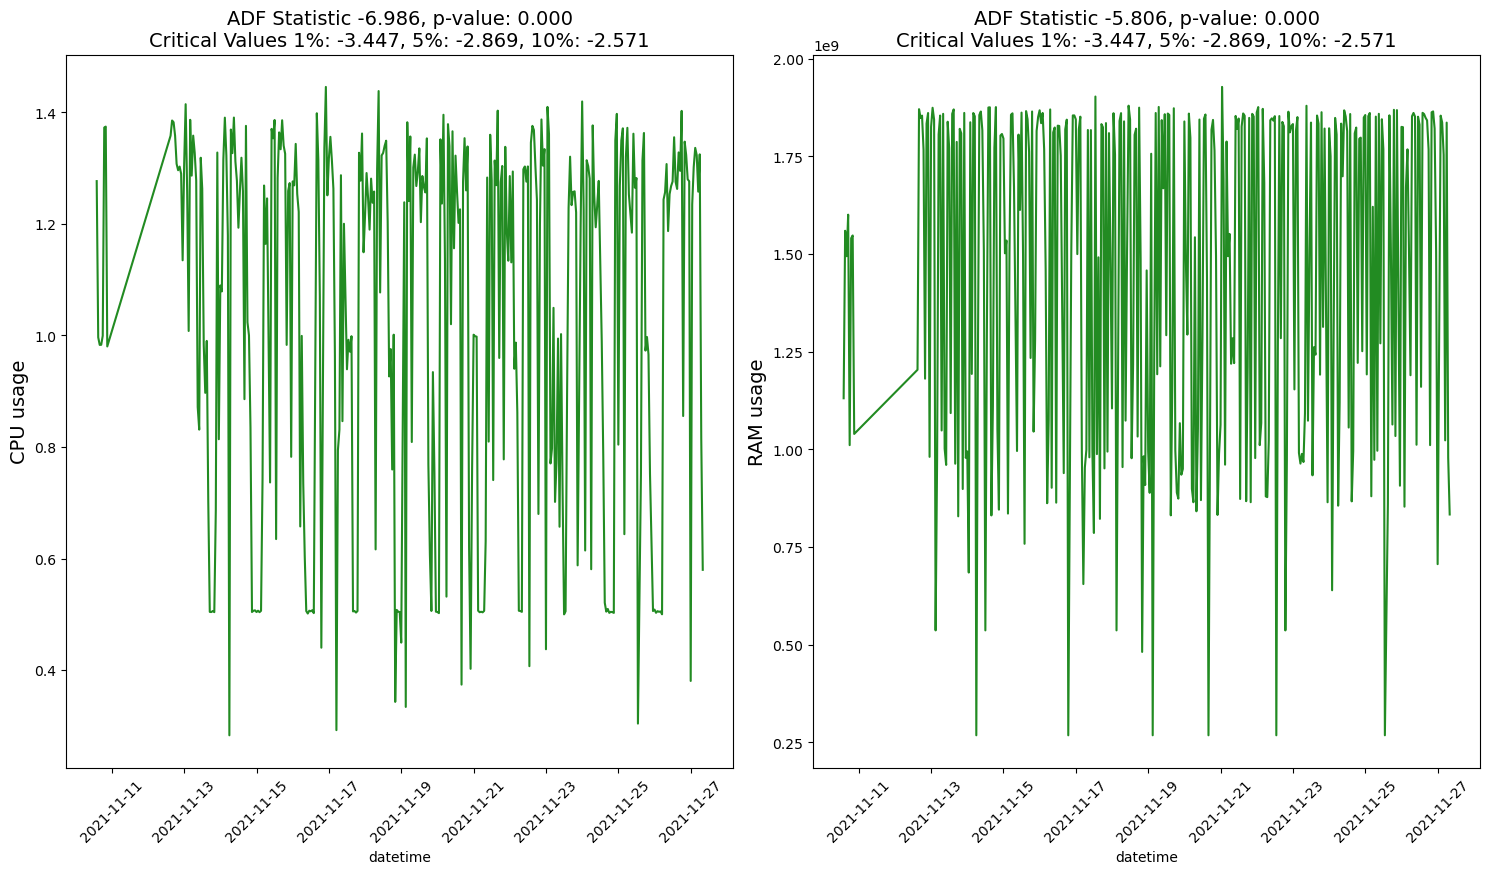

In [45]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df_max['datetime'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df_max['cpu_usage'].values, 'CPU usage', ax[0])
visualize_adfuller_results(df_max['ram_usage'].values, 'RAM usage', ax[1])

# Rotating x-axis labels in all subplots
for ax in ax:
    ax.tick_params(axis='x', rotation=45)  # Adjust the rotation angle as needed


plt.tight_layout()
plt.show()

In [46]:
# Fit model
model = ARIMA(y_train_cpu_usage, order=(5,0,5)) # (p,d,q) --> p = lag order, d = degree of differencing, q = order of moving average
model_fit = model.fit()

#model_fit.summary()
y_pred_cpu_usage = model_fit.predict()

# reshape for consistency
y_valid_cpu_usage_res = y_valid_cpu_usage.to_numpy().ravel()
valid_len = len(y_valid_cpu_usage_res)
y_pred_cpu_usage_res = y_pred_cpu_usage[:valid_len]

# Calcuate metrics
score_mae_cpu_usage = mean_absolute_error(y_valid_cpu_usage_res, y_pred_cpu_usage_res)
score_rmse_cpu_usage = math.sqrt(mean_squared_error(y_valid_cpu_usage_res, y_pred_cpu_usage_res))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse_cpu_usage))
print('MAE: {}'.format(score_mae_cpu_usage))


RMSE: 0.35321238821431844
MAE: 0.28116686989341094


C:\Users\Alice Piemonti\.conda\envs\6g-ntn\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


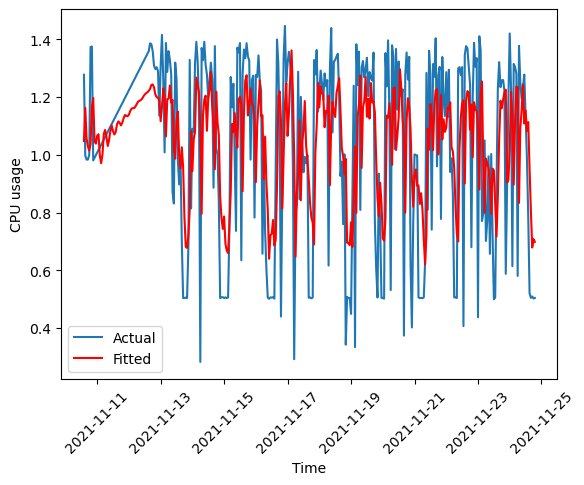

In [47]:
plt.plot(y_train_cpu_usage.set_index(x_train_cpu_usage['ds']))
plt.plot(pd.DataFrame(model_fit.fittedvalues).set_index(x_train_cpu_usage['ds']), color='red')
#plt.title('RSS: %.4f' % sum((model_fit.fittedvalues - y_train_cpu_usage) ** 2))
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('CPU usage')
plt.legend(['Actual', 'Fitted'])
plt.show()

Parameters: (p=0, d=0, q=0)
RMSE: 0.34707221364259605
MAE: 0.3146379575681351
MAPE: 0.42774581599800643

Parameters: (p=0, d=0, q=1)
RMSE: 0.3437061977699235
MAE: 0.31217937414647756
MAPE: 0.42275458887205447

Parameters: (p=0, d=0, q=2)
RMSE: 0.340658669067941
MAE: 0.30983452773144926
MAPE: 0.41793132399372346

Parameters: (p=0, d=0, q=5)
RMSE: 0.3404234485992583
MAE: 0.30942857039699456
MAPE: 0.41311259067071393

Parameters: (p=0, d=1, q=0)
RMSE: 0.6446947245908456
MAE: 0.5542277622950819
MAPE: 0.46083531248186005

Parameters: (p=0, d=1, q=1)
RMSE: 0.6248344077088269
MAE: 0.5388335984713463
MAPE: 0.45196858547671986

Parameters: (p=0, d=1, q=2)
RMSE: 0.577771418572641
MAE: 0.5038532054147248
MAPE: 0.43499833269093297

Parameters: (p=0, d=1, q=5)
RMSE: 0.34339204681580515
MAE: 0.31881239812759904
MAPE: 0.41028833026827033

Parameters: (p=1, d=0, q=0)
RMSE: 0.3404493893886436
MAE: 0.30980841909761864
MAPE: 0.4152361234093881

Parameters: (p=1, d=0, q=1)
RMSE: 0.34313220457761984
MAE: 0

C:\Users\Alice Piemonti\.conda\envs\6g-ntn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Alice Piemonti\.conda\envs\6g-ntn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Parameters: (p=2, d=0, q=2)
RMSE: 0.34396029619127555
MAE: 0.31273328102055165
MAPE: 0.4129721336386113

Parameters: (p=2, d=0, q=5)
RMSE: 0.34418874681596917
MAE: 0.3120254138799301
MAPE: 0.41107629764399306

Parameters: (p=2, d=1, q=0)
RMSE: 0.6445750911641385
MAE: 0.5541236119929135
MAPE: 0.46075839417459036

Parameters: (p=2, d=1, q=1)
RMSE: 0.34368627429868087
MAE: 0.3168222909267453
MAPE: 0.4094117685806667

Parameters: (p=2, d=1, q=2)
RMSE: 0.3435522117540672
MAE: 0.31846871518131953
MAPE: 0.41055487197332896



C:\Users\Alice Piemonti\.conda\envs\6g-ntn\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Parameters: (p=2, d=1, q=5)
RMSE: 0.3477710995641099
MAE: 0.3219976324825511
MAPE: 0.40773499678442404

Parameters: (p=5, d=0, q=0)
RMSE: 0.34741450112783556
MAE: 0.3155814452819526
MAPE: 0.41245961155421523

Parameters: (p=5, d=0, q=1)
RMSE: 0.34594701769684977
MAE: 0.3142523129811256
MAPE: 0.412373547716673



C:\Users\Alice Piemonti\.conda\envs\6g-ntn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Alice Piemonti\.conda\envs\6g-ntn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Parameters: (p=5, d=0, q=2)
RMSE: 0.3450191765554184
MAE: 0.3133988292591693
MAPE: 0.41232628098513563



C:\Users\Alice Piemonti\.conda\envs\6g-ntn\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Parameters: (p=5, d=0, q=5)
RMSE: 0.34062063454230485
MAE: 0.3078183330931977
MAPE: 0.41096765452296785

Parameters: (p=5, d=1, q=0)
RMSE: 0.6422550004861715
MAE: 0.5522326425532005
MAPE: 0.45952469976766896

Parameters: (p=5, d=1, q=1)
RMSE: 0.34930582648788827
MAE: 0.31908333854657284
MAPE: 0.4105082130218344



C:\Users\Alice Piemonti\.conda\envs\6g-ntn\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Parameters: (p=5, d=1, q=2)
RMSE: 0.3477857545305295
MAE: 0.3181219609087926
MAPE: 0.41016492467480586



C:\Users\Alice Piemonti\.conda\envs\6g-ntn\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Parameters: (p=5, d=1, q=5)
RMSE: 0.34459611415501634
MAE: 0.31986794162128057
MAPE: 0.40647354579276934



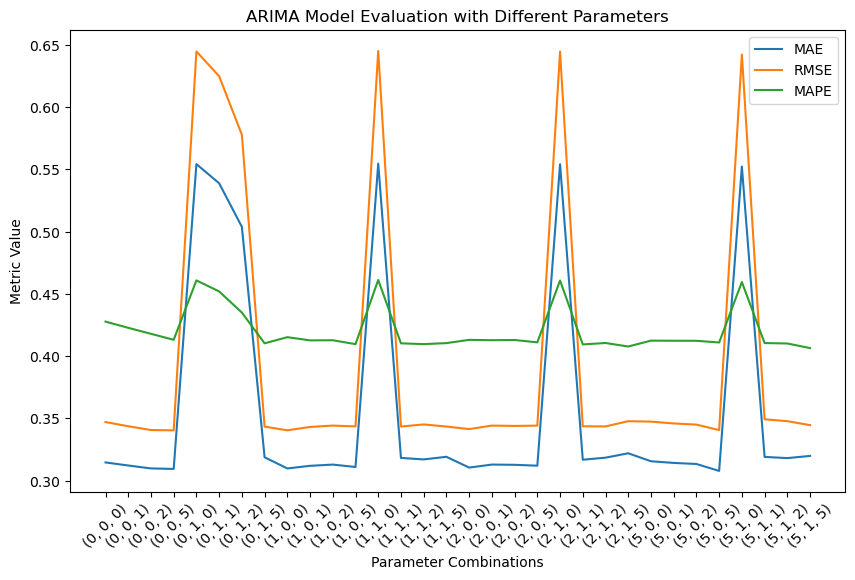

In [48]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import math
from colorama import Fore  # For colored terminal output

# Sample data (replace this with your actual data)
np.random.seed(42)

# Define parameter combinations to iterate over
p_values = [0, 1, 2, 5]
d_values = [0, 1]
q_values = [0, 1, 2, 5]

# Store results in a dictionary
results = {}

# Iterate over parameter combinations
for p in p_values:
    for d in d_values:
        for q in q_values:
            # Fit model
            model = ARIMA(y_train_cpu_usage, order=(p, d, q))
            model_fit = model.fit()

            # Predict on validation set
            y_pred_cpu_usage = model_fit.predict(start=len(y_train_cpu_usage), end=len(y_train_cpu_usage) + len(y_valid_cpu_usage) - 1)

            # Calculate metrics
            score_mae_cpu_usage = mean_absolute_error(y_valid_cpu_usage, y_pred_cpu_usage)
            score_rmse_cpu_usage = math.sqrt(mean_squared_error(y_valid_cpu_usage, y_pred_cpu_usage))
            score_mape_cpu_usage = mean_absolute_percentage_error(y_valid_cpu_usage, y_pred_cpu_usage)

            # Store results in the dictionary
            results[(p, d, q)] = {'MAE': score_mae_cpu_usage, 'RMSE': score_rmse_cpu_usage, 'MAPE': score_mape_cpu_usage}

            print(Fore.GREEN + f'Parameters: (p={p}, d={d}, q={q})')
            print(f'RMSE: {score_rmse_cpu_usage}')
            print(f'MAE: {score_mae_cpu_usage}')
            print(f'MAPE: {score_mape_cpu_usage}')
            print(Fore.RESET)

# Convert results dictionary to a DataFrame for easy plotting
results_df = pd.DataFrame(results).T

# Plotting
plt.figure(figsize=(10, 6))
for metric in ['MAE', 'RMSE', 'MAPE']:
    plt.plot(results_df.index.map(str), results_df[metric], label=metric)

plt.title('ARIMA Model Evaluation with Different Parameters')
plt.xlabel('Parameter Combinations')
plt.ylabel('Metric Value')
plt.legend()
plt.xticks(rotation=45)
plt.show()
